<a href="https://colab.research.google.com/github/mrMichalR/AI_for_industry/blob/main/AI_for_industry_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project: AI for the Industry 4.0

## Description

A company producing fiber optic sensors decided to implement the concept
of Industry 4.0 in one of their production processes. They are going to
implement the AI techniques to automate verification of produced sensors.
Currently, after the production of the sensor, its characteristics should be
verified each time in three reference substances in order to configure:

*   Air
*   Water
*   Isopropanol

After the procedure in the laboratory they collected three spectroscopic
signals. Unfortunately, such procedures are extremely time consuming and
require large human resources. Therefore they are planning to implement AI
algorithms in order to predict characteristics (or any other parameters – you
can propose something) of a working sensor in water and isopropanol based
on measured characteristics in air. It will enable to reduce validation process
only to measurements in the air, but other characteristics will be collected
based on the proposed model.

Dataset of manufactured sensors are collected in the google drive:
https://drive.google.com/drive/folders/1ha7P4Mwp6_XYnUHs20460CbBC4zwNvf9?usp=share_link

It's a collection of measurements based on 10 sensors . Each sensor was
measured three times that you can find in three separated files (e.g.
sensor01_air.txt, sensor01_water.txt, sensor01_izopropanol.txt). Each file
contains two-dimensional signal (signal wavelength, signal amplitude) as you
can observe in figure 1.

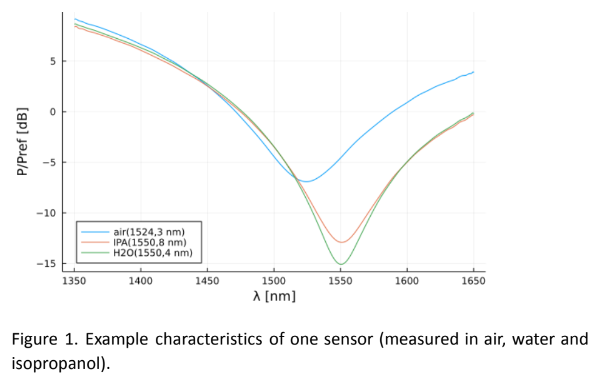

Based on this characteristics you can use any data mining and machine
learning techniques. Of course you can use any mechanisms e.g. data
enrichment, feature extraction, signal analysis, etc. The ultimate goal of this
task is facing the real problem and design and plan AI implementation plan
as follows:

1. Prepare a demonstration of your concept of this project in order to
convince the client of your idea (you can use any tools).
2. Implement your solution using the Google Colab tool.
3. Prepare publication of your preliminary results.
4. Share all materials from points 1, 2 and 3 in your personal GitHub or
GitLab account and send us the link.

# Concept

* Problem seems to be non-linear regression problem so algorithms taken under consideration are e.g. Polynomial LR, SVR, KNregressor, Lasso, ElasticNet.
* As bonus ensemble methods to be used.
* Standard data check (data types, missing values, outliers).
* As a target value for water and isopropanol mean value of 10 sensors will be taken.

## Initial thoughts

* Checking the fiber optic characteristic wave length starts at 0,8nm. This data seems to be only part of whole charateristic. Somewhere between 2nd and 3rd window ('water peak' area)

http://fowiki.com/b/understand-fiber-attenuation/ 

* The lower y value, the bigger attenuation which gives signal loss.


# Load libraries


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, sys
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from pandas import set_option
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# url_folder='https://github.com/mrMichalR/AI_for_industry/tree/main/Dataset/sesion_01_20'

Place Dataset folder in Google drive to load it by below code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/Dataset

Mounted at /content/drive
/content/drive/MyDrive/Dataset


# Data preparation & analysis

## Load files

In [ ]:
air_list = []
iso_list = []
water_list = []
files_list=[]

root = os.getcwd()
path = os.path.join(root, ".txt")


for path, subdirs, files in os.walk(root):
  for name in files:
    file_path = os.path.join(path, name)
    if name.endswith('air.txt'):
      air_list.append(file_path)
    if name.endswith('izopropanol.txt'):
      iso_list.append(file_path)
    if name.endswith('water.txt'):
      water_list.append(file_path)


air_list_sort = np.sort(air_list)
iso_list_sort = np.sort(iso_list)
water_list_sort = np.sort(water_list)

print('Sorted air list: \n', air_list_sort)
print('Sorted isopropanol list: \n', iso_list_sort)
print('Sorted water list: \n', water_list_sort)

Sorted air list: 
 ['/content/drive/MyDrive/Dataset/sesion_01_20/sensor01_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_02_20/sensor02_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_03_20/sensor03_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_04_20/sensor04_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_05_20/sensor05_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_06_20/sensor06_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_07_20/sensor07_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_08_20/sensor08_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_09_20/sensor09_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_10_20/sensor10_air.txt']
Sorted isopropanol list: 
 ['/content/drive/MyDrive/Dataset/sesion_01_20/sensor01_izopropanol.txt'
 '/content/drive/MyDrive/Dataset/sesion_02_20/sensor02_izopropanol.txt'
 '/content/drive/MyDrive/Dataset/sesion_03_20/sensor03_izopropanol.txt'
 '/content/drive/MyDrive/Dataset/sesion_04_20/sensor04_izopropanol.txt'
 '/content/drive/MyDrive/

In [ ]:
def create_df (feature_name_list):
  new_df_list=[]
  for elem in feature_name_list:
    new_df = pd.read_csv(elem, sep=',', header=None)
    new_df_list.append(new_df)
  df = pd.concat(new_df_list, axis=1, ignore_index=False)
  return df

In [ ]:
air_reduced = create_df(air_list_sort).loc[:,~create_df(air_list_sort).T.duplicated(keep='first')]
iso_reduced = create_df(iso_list_sort).loc[:,~create_df(iso_list_sort).T.duplicated(keep='first')]
water_reduced = create_df(water_list_sort).loc[:,~create_df(water_list_sort).T.duplicated(keep='first')]

In [ ]:
air_reduced.head(10)

,0,1,1,1,1,1,1,1,1,1,1
0,0.000001,9.1792,9.7793,7.8831,8.0963,9.4439,9.4554,8.8064,9.9081,8.6910,9.2124
1,0.000001,9.2003,9.8643,8.0971,8.1872,9.6645,9.6052,8.9714,10.0010,8.7223,9.2734
2,0.000001,9.1968,9.8031,7.9478,8.2061,9.5697,9.6264,8.9747,9.9366,8.7796,9.1703
3,0.000001,9.1028,9.7320,7.9979,8.1094,9.6378,9.5136,8.8461,9.8126,8.6753,9.2478
4,0.000001,9.0601,9.6895,7.9220,7.9691,9.4933,9.4042,8.8265,9.8773,8.6667,9.0771
5,0.000001,9.1118,9.6751,7.9398,7.9983,9.4646,9.3976,8.7838,9.7859,8.6335,9.2124
6,0.000001,9.1082,9.8390,7.9327,8.1034,9.5433,9.4297,8.8814,9.8417,8.7144,9.2134
7,0.000001,9.1401,9.7645,7.9529,8.0671,9.5420,9.5126,8.8718,9.8616,8.7337,9.2372
8,0.000001,9.2533,9.8178,8.0276,8.2137,9.5720,9.5449,9.0086,9.9351,8.7412,9.3312
9,0.000001,9.1403,9.8695,7.9734,7.9368,9.5126,9.4615,8.8919,9.8413,8.6552,9.1411


In [ ]:
iso_reduced.head(10)

,0,1,1,1,1,1,1,1,1,1,1
0,0.000001,8.5551,9.2544,7.3432,7.4954,8.9739,8.8085,8.2594,9.3247,8.1031,8.7030
1,0.000001,8.6750,9.3012,7.4798,7.6049,9.0295,9.0038,8.3246,9.4571,8.2641,8.7322
2,0.000001,8.7116,9.2512,7.4810,7.5770,8.9789,8.9254,8.2975,9.3304,8.2080,8.6748
3,0.000001,8.7157,9.2734,7.4719,7.4928,8.9369,8.8786,8.3300,9.3175,8.1822,8.5932
4,0.000001,8.6792,9.1999,7.3330,7.4703,8.9419,8.8290,8.2628,9.2751,8.0794,8.5665
5,0.000001,8.6312,9.1273,7.3773,7.4842,8.8595,8.8734,8.2826,9.3226,8.0380,8.5684
6,0.000001,8.5790,9.2143,7.4270,7.5368,8.9942,8.9079,8.2182,9.3161,8.0850,8.5508
7,0.000001,8.7378,9.2502,7.3881,7.4911,8.9808,8.8774,8.2864,9.2406,8.2056,8.6063
8,0.000001,8.7874,9.3900,7.4502,7.6697,9.0207,8.9629,8.3294,9.5515,8.2634,8.7008
9,0.000001,8.5679,9.2200,7.3618,7.5023,8.9267,8.8763,8.2688,9.2987,8.1004,8.5083


In [ ]:
water_reduced.head(10)

,0,1,1,1,1,1,1,1,1,1,1
0,0.000001,8.3570,9.0607,7.2354,7.3714,8.6370,8.7331,8.1180,9.1633,7.8706,8.3966
1,0.000001,8.4287,9.1238,7.3520,7.3794,8.8197,8.7934,8.2177,9.2473,8.0872,8.5327
2,0.000001,8.4422,9.1159,7.3746,7.3017,8.7279,8.7887,8.0696,9.2127,8.0130,8.4086
3,0.000001,8.4144,9.0431,7.2810,7.2528,8.7620,8.7277,8.1302,9.1313,7.9647,8.4676
4,0.000001,8.4034,8.9860,7.0982,7.2032,8.7683,8.7171,7.9694,9.0760,7.9518,8.3277
5,0.000001,8.3351,9.0339,7.1982,7.2758,8.7061,8.7221,8.0236,9.1281,7.8739,8.4390
6,0.000001,8.2999,9.0202,7.1621,7.2670,8.7494,8.6598,8.1107,9.1439,7.9986,8.4466
7,0.000001,8.4229,9.1341,7.2401,7.3706,8.7382,8.7003,8.1325,9.2849,7.9623,8.4476
8,0.000001,8.5613,9.2108,7.3294,7.3727,8.7636,8.8810,8.2029,9.2166,7.9913,8.4513
9,0.000001,8.4437,8.9912,7.2356,7.2238,8.7546,8.7577,8.0463,9.0608,7.8490,8.3854


In [ ]:
air_reduced.columns

Int64Index([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype='int64')

## Rename columns

In [ ]:
new_names=[]
for cols in range(len(air_reduced.columns)):
  new='sensor_' + str(cols)
  print(new)
  new_names.append(new)
new_names[0]='wave_length'

# Assining new names to columns
air_reduced.columns = new_names
iso_reduced.columns = new_names
water_reduced.columns = new_names

sensor_0
sensor_1
sensor_2
sensor_3
sensor_4
sensor_5
sensor_6
sensor_7
sensor_8
sensor_9
sensor_10


In [ ]:
air = air_reduced
iso = iso_reduced
water = water_reduced

In [ ]:
set_option('display.precision', 10)
air

,wave_length,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,0.0000013500,9.1792,9.7793,7.8831,8.0963,9.4439,9.4554,8.8064,9.9081,8.6910,9.2124
1,0.0000013501,9.2003,9.8643,8.0971,8.1872,9.6645,9.6052,8.9714,10.0010,8.7223,9.2734
2,0.0000013502,9.1968,9.8031,7.9478,8.2061,9.5697,9.6264,8.9747,9.9366,8.7796,9.1703
3,0.0000013503,9.1028,9.7320,7.9979,8.1094,9.6378,9.5136,8.8461,9.8126,8.6753,9.2478
4,0.0000013504,9.0601,9.6895,7.9220,7.9691,9.4933,9.4042,8.8265,9.8773,8.6667,9.0771
...,...,...,...,...,...,...,...,...,...,...,...
2996,0.0000016496,3.8310,3.5505,2.3074,1.5783,2.8330,2.4787,2.9408,3.7791,2.7312,3.2784
2997,0.0000016497,3.8613,3.8237,2.3935,1.7888,2.9789,2.9384,3.2277,3.6568,2.7287,3.4213
2998,0.0000016498,3.8361,3.6708,2.2550,1.3259,2.7841,2.4859,2.8527,3.7064,2.5725,3.3112
2999,0.0000016499,3.9466,3.8785,2.4935,1.6945,2.9465,2.9317,3.3101,3.7920,2.7335,3.4500


## Decriptive analysis

In [ ]:
air.head()

,wave_length,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,0.0000013500,9.1792,9.7793,7.8831,8.0963,9.4439,9.4554,8.8064,9.9081,8.6910,9.2124
1,0.0000013501,9.2003,9.8643,8.0971,8.1872,9.6645,9.6052,8.9714,10.0010,8.7223,9.2734
2,0.0000013502,9.1968,9.8031,7.9478,8.2061,9.5697,9.6264,8.9747,9.9366,8.7796,9.1703
3,0.0000013503,9.1028,9.7320,7.9979,8.1094,9.6378,9.5136,8.8461,9.8126,8.6753,9.2478
4,0.0000013504,9.0601,9.6895,7.9220,7.9691,9.4933,9.4042,8.8265,9.8773,8.6667,9.0771


In [ ]:
for elem in [air,iso,water]:
  print(elem.info(),2*'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   wave_length  3001 non-null   float64
 1   sensor_1     3001 non-null   float64
 2   sensor_2     3001 non-null   float64
 3   sensor_3     3001 non-null   float64
 4   sensor_4     3001 non-null   float64
 5   sensor_5     3001 non-null   float64
 6   sensor_6     3001 non-null   float64
 7   sensor_7     3001 non-null   float64
 8   sensor_8     3001 non-null   float64
 9   sensor_9     3001 non-null   float64
 10  sensor_10    3001 non-null   float64
dtypes: float64(11)
memory usage: 258.0 KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   wave_length  3001 non-null   float64
 1   sensor_1     3001 non-null   float64
 2   sensor_2     300

In [ ]:
for elem in [air,iso,water]:
  print(elem.isnull().any(),2*'\n')

wave_length    False
sensor_1       False
sensor_2       False
sensor_3       False
sensor_4       False
sensor_5       False
sensor_6       False
sensor_7       False
sensor_8       False
sensor_9       False
sensor_10      False
dtype: bool 


wave_length    False
sensor_1       False
sensor_2       False
sensor_3       False
sensor_4       False
sensor_5       False
sensor_6       False
sensor_7       False
sensor_8       False
sensor_9       False
sensor_10      False
dtype: bool 


wave_length    False
sensor_1       False
sensor_2       False
sensor_3       False
sensor_4       False
sensor_5       False
sensor_6       False
sensor_7       False
sensor_8       False
sensor_9       False
sensor_10      False
dtype: bool 




In [ ]:
set_option('display.precision', 2)
for elem in [air,iso,water]:
  print(elem.describe(),2*'\n')

       wave_length  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
count     3.00e+03   3001.00   3001.00   3001.00   3001.00   3001.00   
mean      1.50e-06      1.19      1.44     -0.25     -0.26      1.26   
std       8.66e-08      4.72      4.93      4.82      4.98      4.88   
min       1.35e-06     -7.15     -7.12     -8.73     -8.80     -6.91   
25%       1.42e-06     -2.63     -2.60     -4.17     -4.38     -2.80   
50%       1.50e-06      1.62      1.72      0.13     -0.13      1.30   
75%       1.57e-06      4.89      5.55      3.58      4.04      5.51   
max       1.65e-06      9.25      9.87      8.10      8.26      9.66   

       sensor_6  sensor_7  sensor_8  sensor_9  sensor_10  
count   3001.00   3001.00   3001.00   3001.00    3001.00  
mean       1.10      0.63      1.54      0.33       1.02  
std        4.96      4.76      4.89      4.90       4.80  
min       -7.28     -7.56     -6.89     -8.22      -7.36  
25%       -3.01     -3.26     -2.48     -3.65      -2.93

In [ ]:
# # correlation
# set_option('display.precision', 2)
# print(air.corr(method='pearson'))

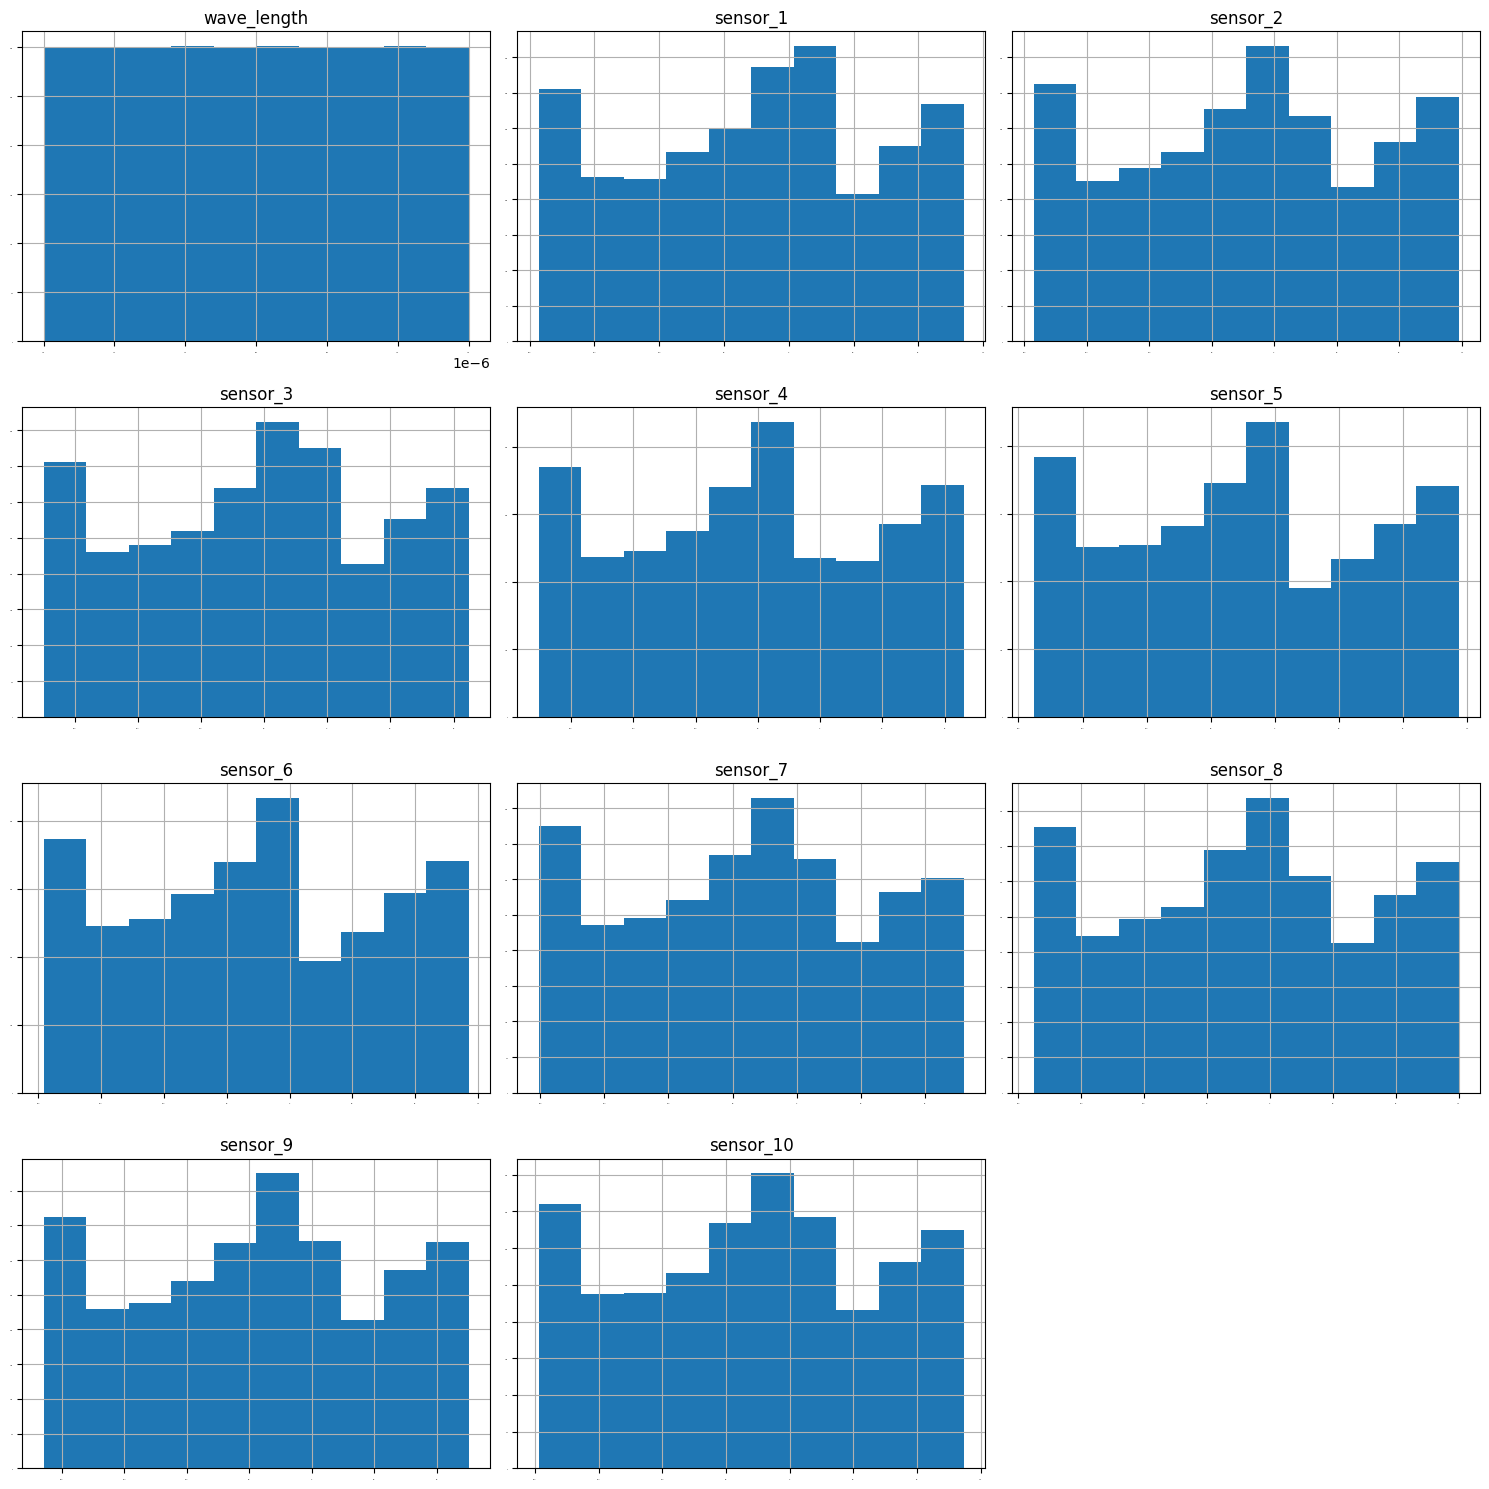

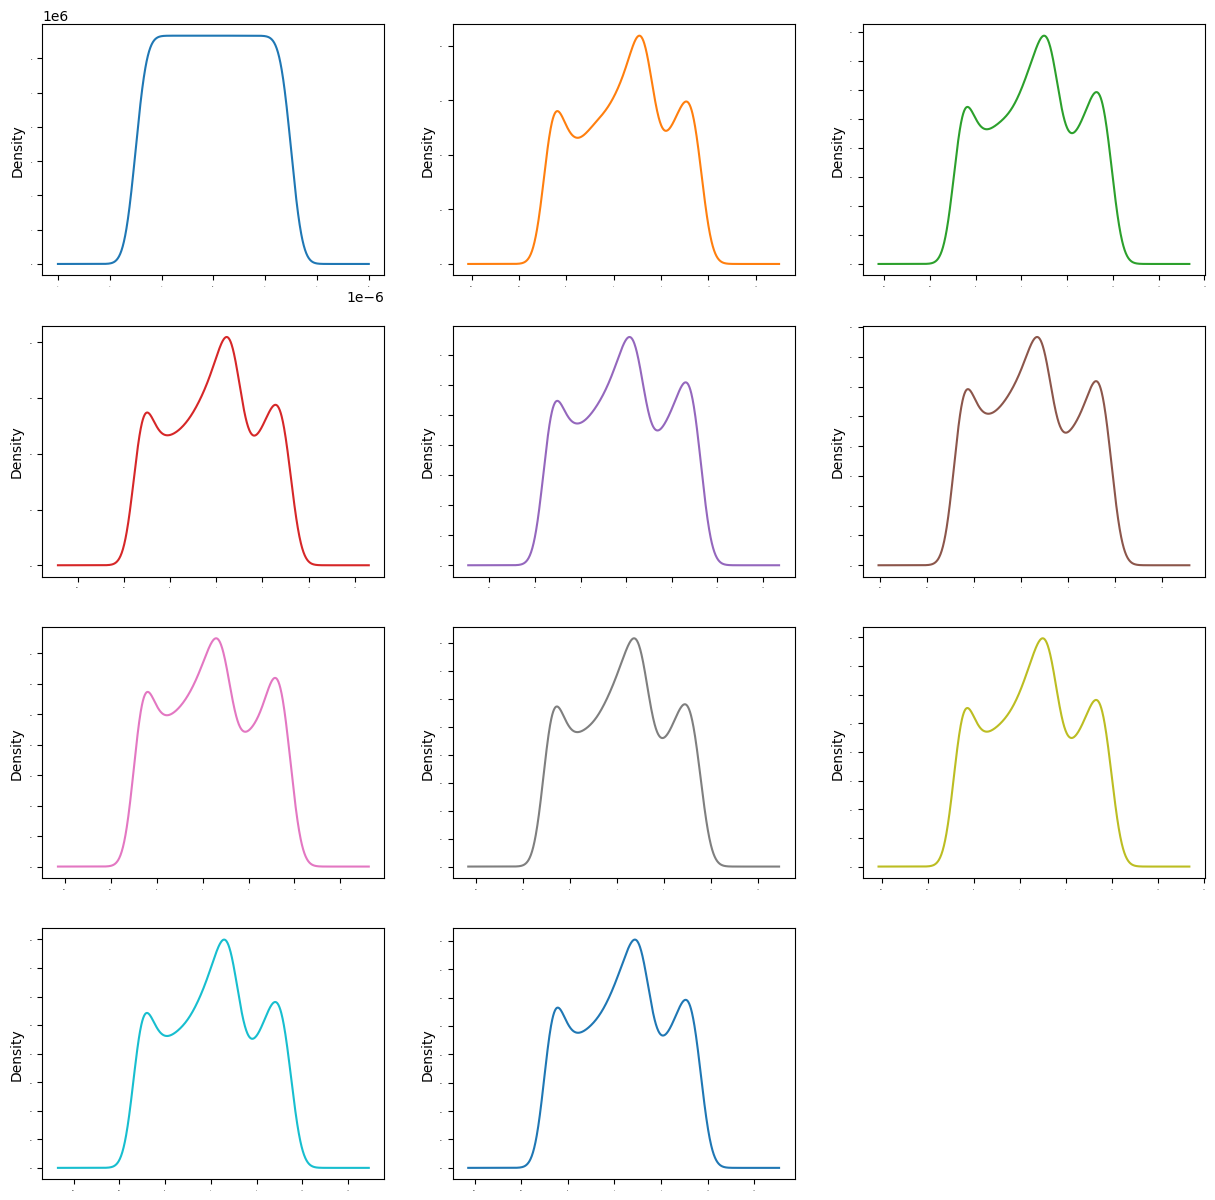

In [ ]:
# histograms of each attribute to get a sense of the data distributions
air.hist(figsize=(15,15), sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.tight_layout()
plt.show()

# density
air.plot(kind='density', figsize=(15,15), subplots=True, layout=(4,3), sharex=False, legend=False, fontsize=1)
plt.show()

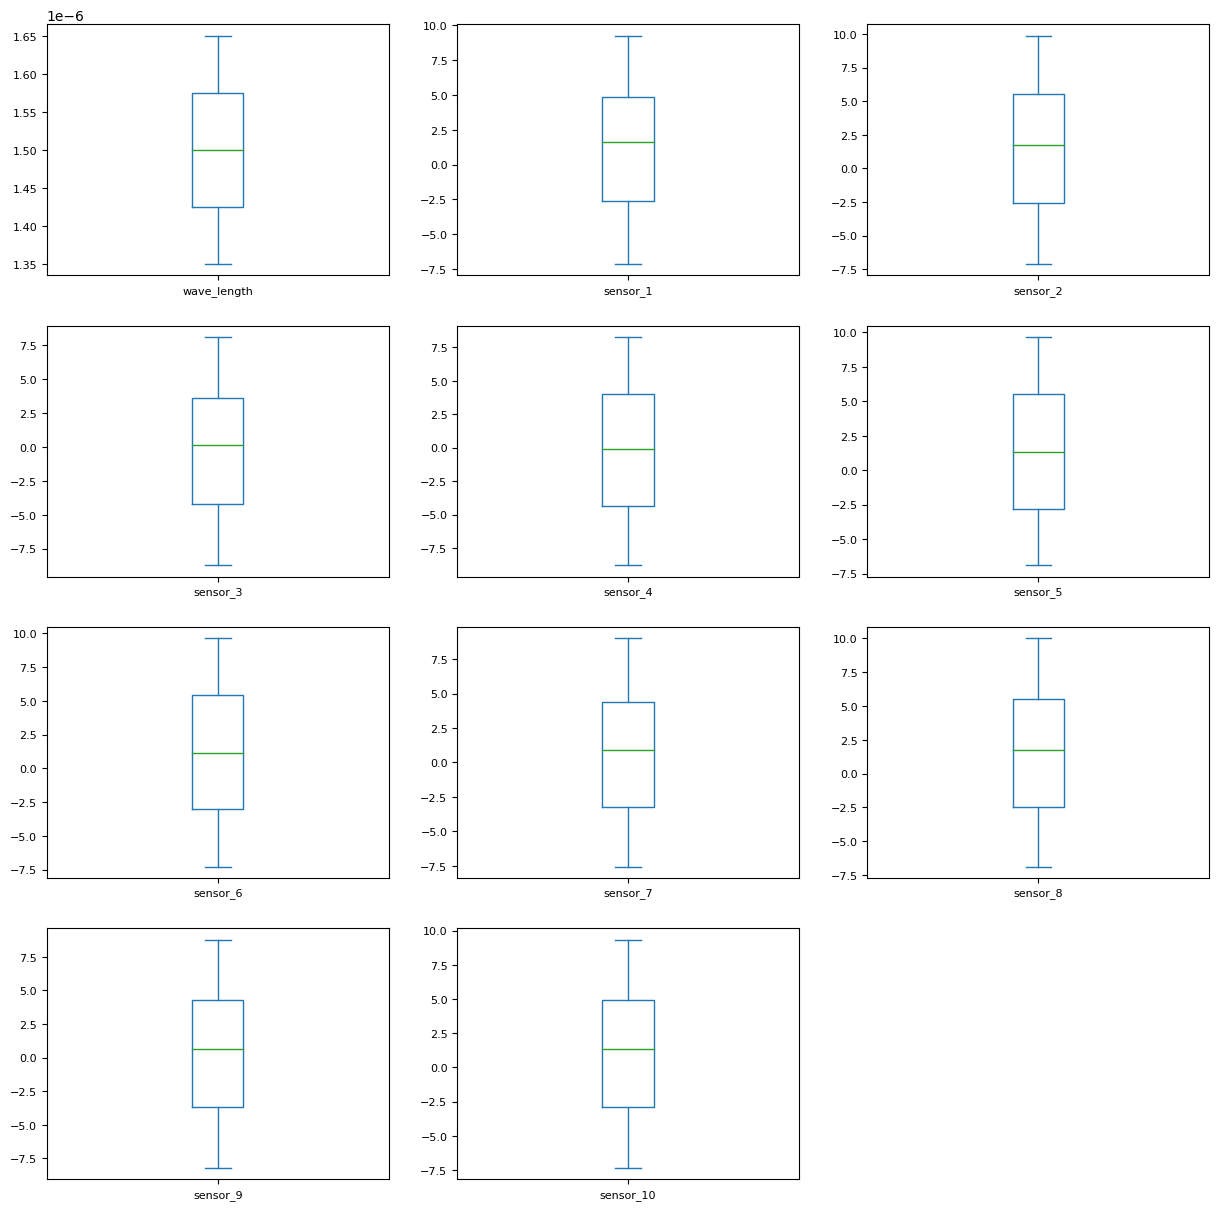

In [ ]:
# box and whisker plots
air.plot(kind='box', figsize=(15,15), subplots=True, layout=(4,3), sharex=False, sharey=False, fontsize=8)
plt.show()

After data analysis decided, for start, to count/create mean value of all 10 sensors signal for each enviroment.

In [ ]:
iso['mean_iso'] = iso.iloc[:, 1:11].mean(axis=1)
print(iso, 3*'\n')

water['mean_water'] = water.iloc[:, 1:11].mean(axis=1)
print(water, 3*'\n')

      wave_length  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  \
0        1.35e-06      8.56  9.25e+00      7.34      7.50      8.97      8.81   
1        1.35e-06      8.68  9.30e+00      7.48      7.60      9.03      9.00   
2        1.35e-06      8.71  9.25e+00      7.48      7.58      8.98      8.93   
3        1.35e-06      8.72  9.27e+00      7.47      7.49      8.94      8.88   
4        1.35e-06      8.68  9.20e+00      7.33      7.47      8.94      8.83   
...           ...       ...       ...       ...       ...       ...       ...   
2996     1.65e-06     -0.34 -3.94e-01     -1.75     -2.47     -1.44     -1.53   
2997     1.65e-06     -0.20 -2.16e-01     -1.42     -2.51     -1.31     -1.40   
2998     1.65e-06     -0.40 -2.97e-01     -1.57     -2.54     -1.40     -1.41   
2999     1.65e-06      0.03 -1.18e-01     -1.44     -2.21     -1.10     -1.13   
3000     1.65e-06     -0.22  1.78e-03     -1.21     -2.27     -1.16     -1.01   

      sensor_7  sensor_8  s

## Summary plot

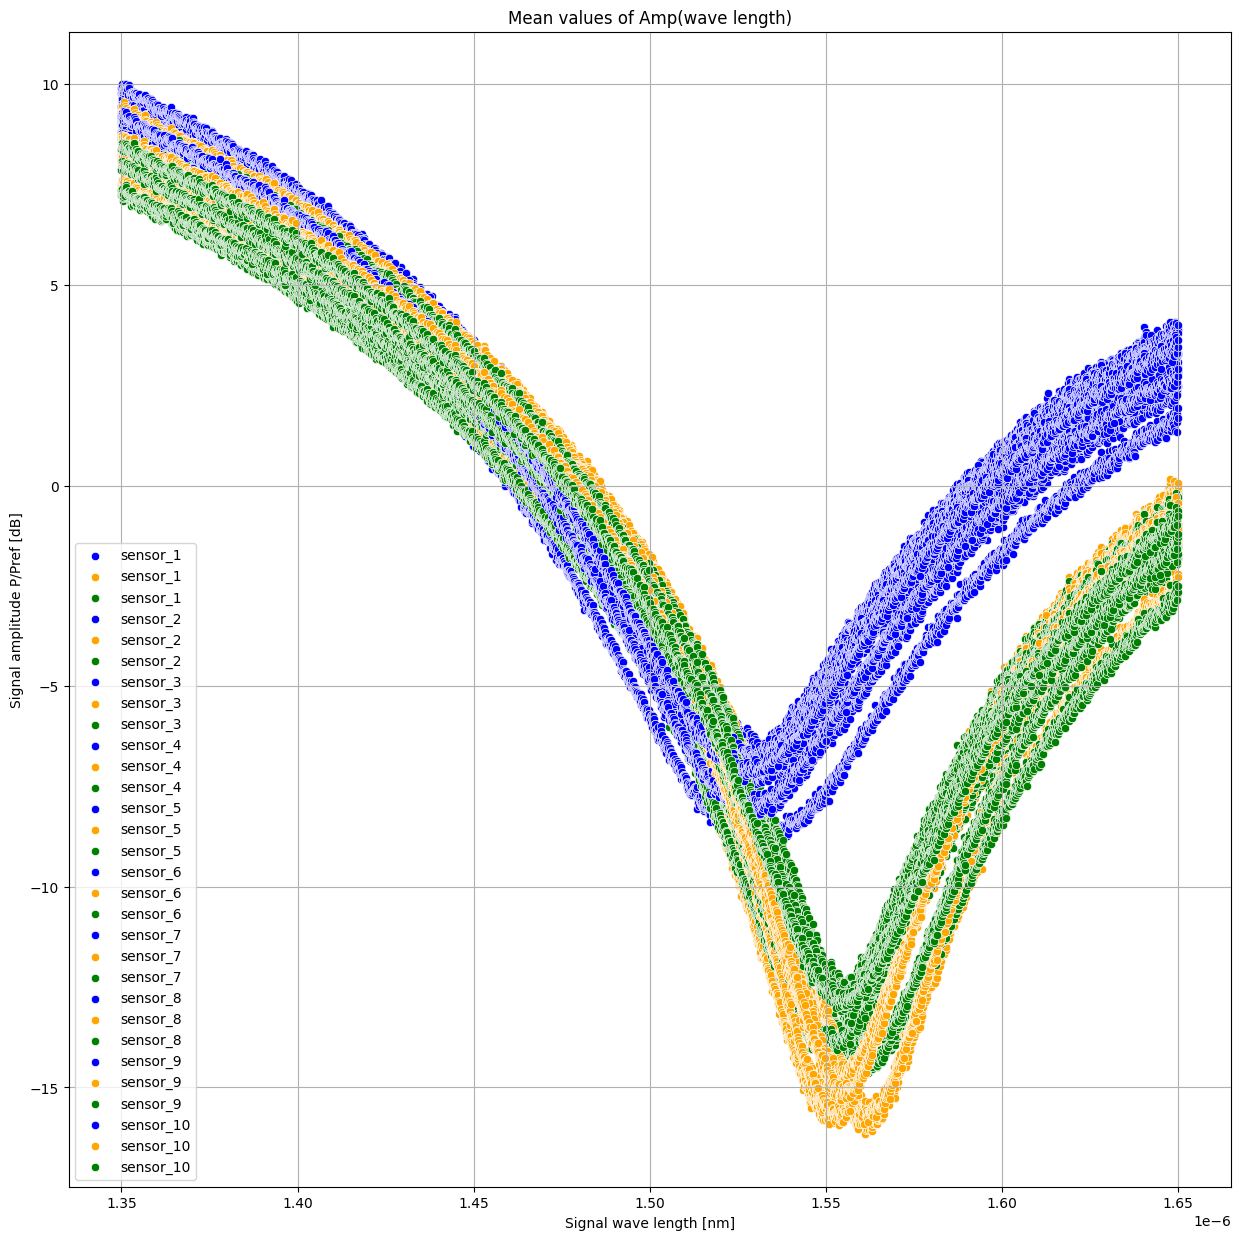

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Mean values of Amp(wave length)")
for col in air.columns[1:11]:
  sns.scatterplot(data=air, x='wave_length', y=col, label=col, color='blue')
  sns.scatterplot(data=iso, x='wave_length', y=col, label=col, color='orange')
  sns.scatterplot(data=water, x='wave_length', y=col, label=col, color='green')
plt.grid()
plt.legend()

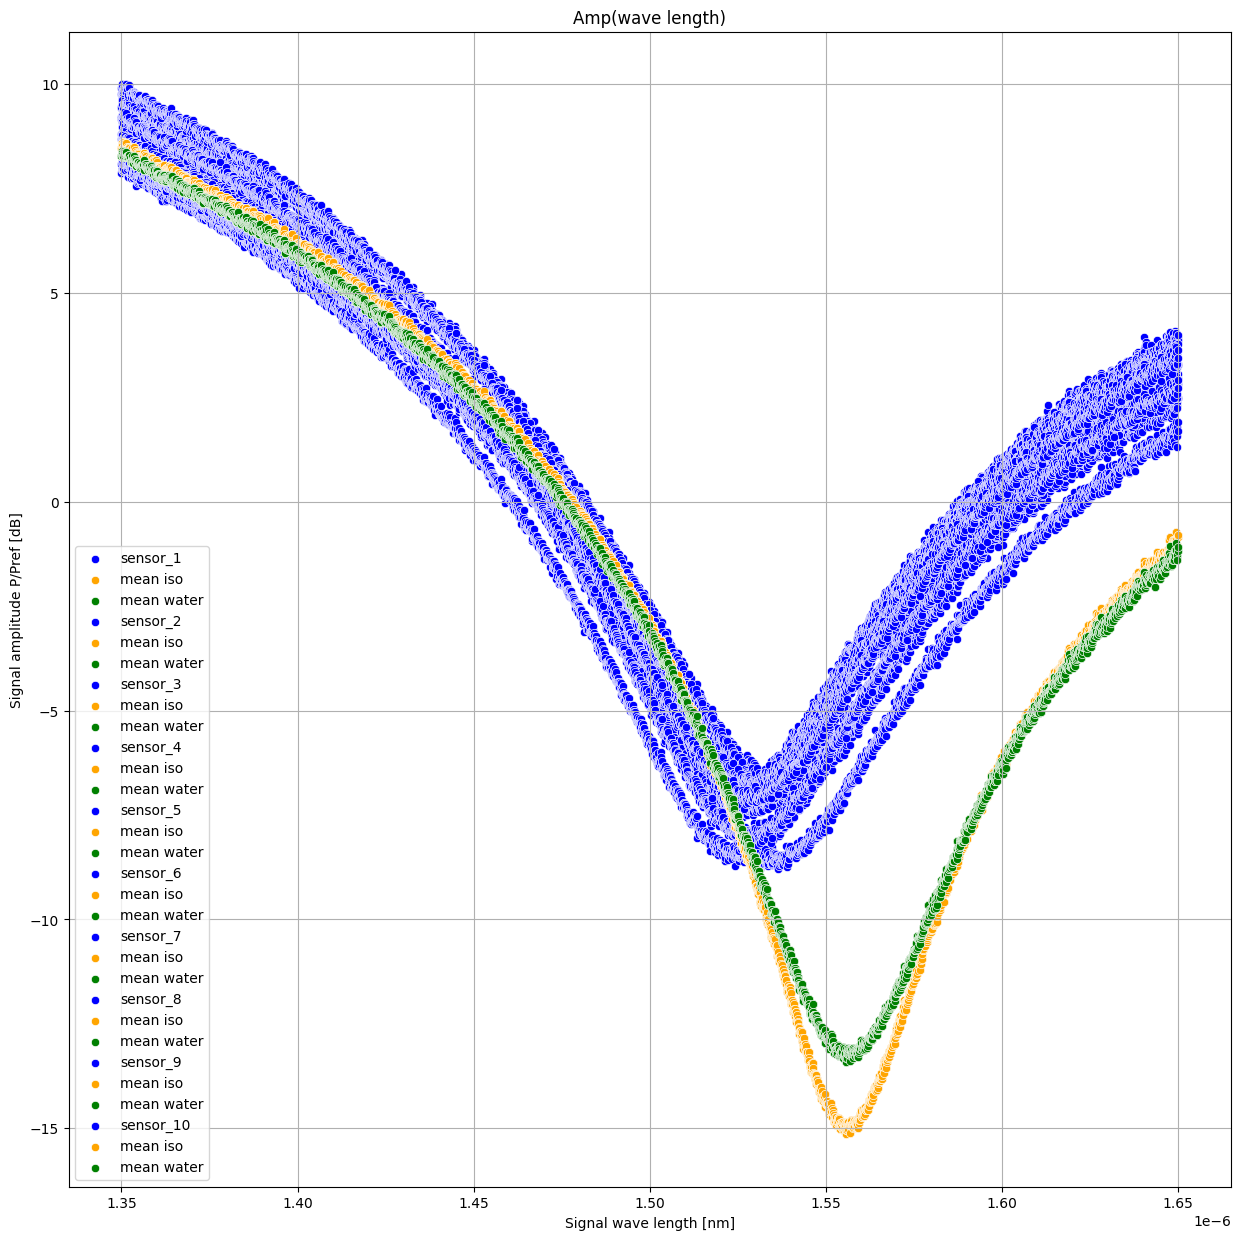

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
for col in air.columns[1:11]:
  sns.scatterplot(data=air, x='wave_length', y=col, label=col, color='blue')
  sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='mean iso', color='orange')
  sns.scatterplot(data=water, x='wave_length', y='mean_water', label='mean water', color='green')
plt.grid()
plt.legend()

## Summary

* **Curves of isopropyl and water seems to be switched!!! Consultation with client or fiber optic specialist needed!**
* no missing values
* no outliers
* uniform data type
* data distribution are similar
* density very similar
* signal amplitude e.g. -5dB for all 3 enviroments can be achieved for two wave lengths. So we need to track the wave length. 

# Model build for Water based on air

In [ ]:
air_water = pd.concat([air,water['mean_water']], axis=1)
set_option('display.precision',10)
air_water

,wave_length,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,mean_water
0,0.0000013500,9.1792,9.7793,7.8831,8.0963,9.4439,9.4554,8.8064,9.9081,8.6910,9.2124,8.294310
1,0.0000013501,9.2003,9.8643,8.0971,8.1872,9.6645,9.6052,8.9714,10.0010,8.7223,9.2734,8.398190
2,0.0000013502,9.1968,9.8031,7.9478,8.2061,9.5697,9.6264,8.9747,9.9366,8.7796,9.1703,8.345490
3,0.0000013503,9.1028,9.7320,7.9979,8.1094,9.6378,9.5136,8.8461,9.8126,8.6753,9.2478,8.317480
4,0.0000013504,9.0601,9.6895,7.9220,7.9691,9.4933,9.4042,8.8265,9.8773,8.6667,9.0771,8.250110
...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0.0000016496,3.8310,3.5505,2.3074,1.5783,2.8330,2.4787,2.9408,3.7791,2.7312,3.2784,-1.320583
2997,0.0000016497,3.8613,3.8237,2.3935,1.7888,2.9789,2.9384,3.2277,3.6568,2.7287,3.4213,-1.282892
2998,0.0000016498,3.8361,3.6708,2.2550,1.3259,2.7841,2.4859,2.8527,3.7064,2.5725,3.3112,-1.391228
2999,0.0000016499,3.9466,3.8785,2.4935,1.6945,2.9465,2.9317,3.3101,3.7920,2.7335,3.4500,-1.165640


##  Dataset split for Water based on Air

In [ ]:
# Split-out validation dataset
X_water_air = air_water.copy() # (features)
y_water_air = X_water_air.pop('mean_water') # (target)

X_train_water_air, X_test_water_air, y_train_water_air, y_test_water_air = train_test_split(X_water_air, y_water_air, test_size=0.20, random_state=42)

print("X_train_water_air dimension = ", X_train_water_air.shape)
print("X_test_water_air dimension = ", X_test_water_air.shape)
print("y_train_water_air dimension = ", y_train_water_air.shape)
print("y_train_water_air dimension = ", y_test_water_air.shape)

X_train_water_air dimension =  (2400, 11)
X_test_water_air dimension =  (601, 11)
y_train_water_air dimension =  (2400,)
y_train_water_air dimension =  (601,)


## Evaluate Algorithms: Baseline

In [ ]:
# Spot-Check Algorithms
models = []
models.append(('KNN', KNeighborsRegressor()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [ ]:
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_water_air, y_train_water_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

KNN: -0.007925 (0.000903)
LASSO: -3.178751 (0.116614)
EN: -2.366876 (0.084590)
CART: -0.146959 (0.091412)
SVR: -0.032178 (0.004114)


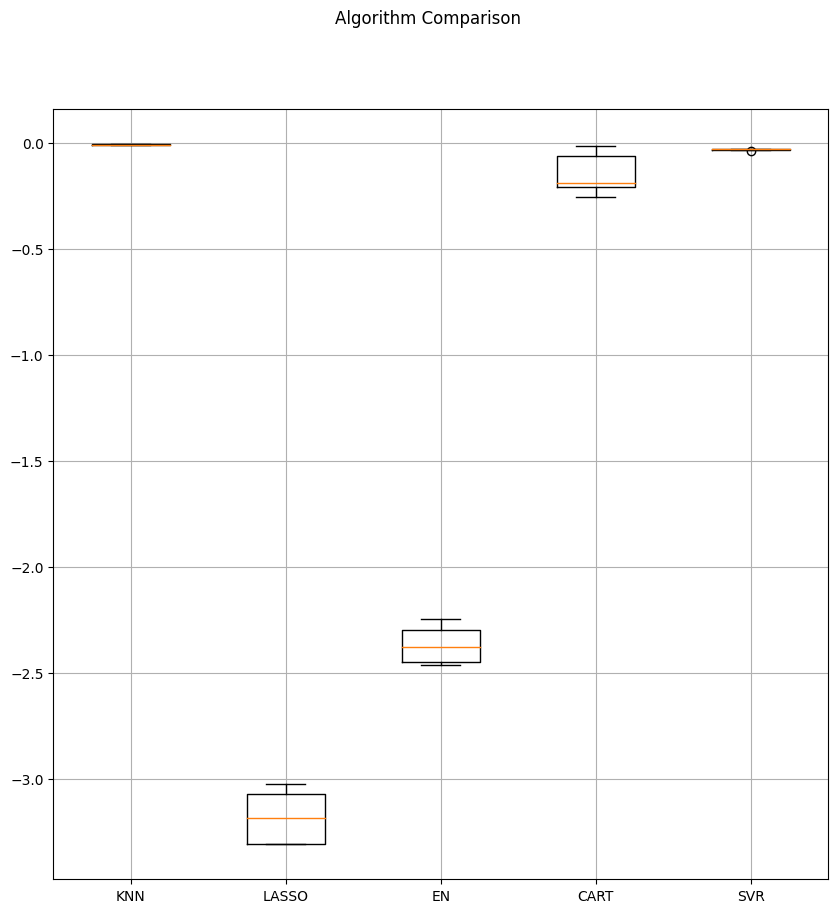

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

Plot-check predictions of baseline



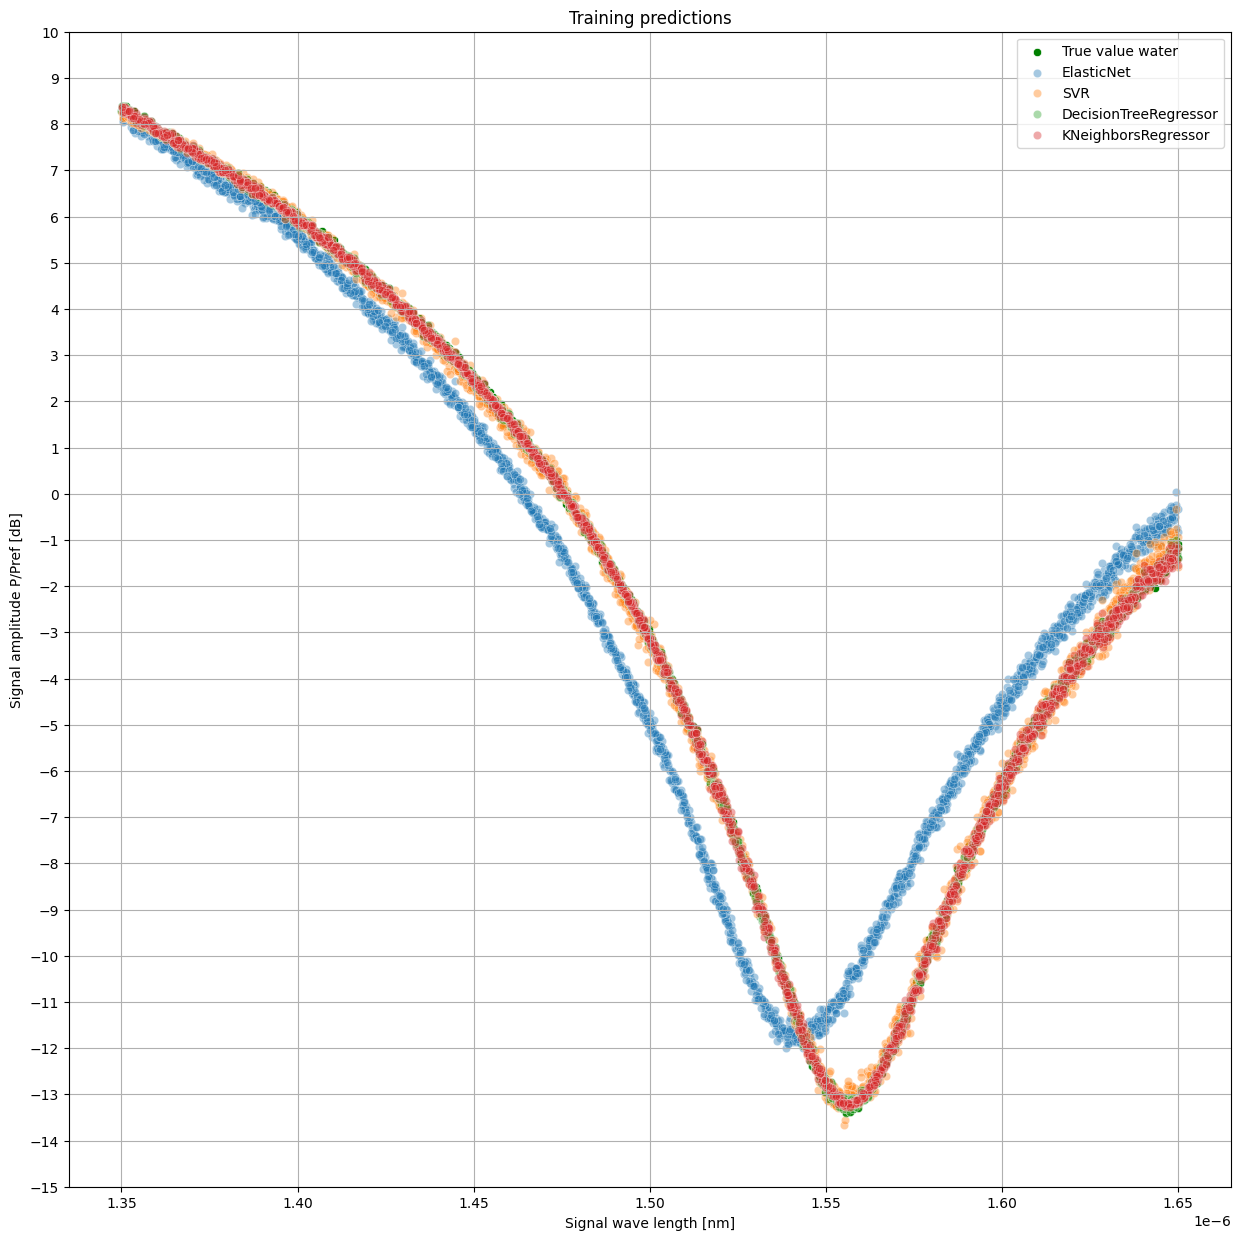

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='True value water', alpha=1, color='green')
sns.scatterplot(data=X_train_water_air, x='wave_length', y=ElasticNet().fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label='ElasticNet', alpha=0.4)
sns.scatterplot(data=X_train_water_air, x='wave_length', y=SVR().fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label='SVR', alpha=0.4)
sns.scatterplot(data=X_train_water_air, x='wave_length', y=DecisionTreeRegressor().fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label='DecisionTreeRegressor', alpha=0.4)
sns.scatterplot(data=X_train_water_air, x='wave_length', y=KNeighborsRegressor().fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label='KNeighborsRegressor',alpha=0.4)
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Training predictions")
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

SUMMARY:

* Best score has KNN regressor, the second is CART. Both have error around 0. That is suspicious - need to check results with non-default parameters.

* 3rd place has ElasticNet with error -2,3 which is good for first try. Also Lasso has error -3. But since ElasticNet is regression with combined L1 and L2, Lasso will not be taken under consideration.

* The worst is SVR, error -10. Probably default kernel needs to be changed and/or data preparation - rescaling etc.

## Evaluate Algorithm: PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree=2)
model_poly = LinearRegression()

X_train_poly = poly.fit_transform(X_train_water_air)
X_test_poly = poly.transform(X_test_water_air)

model_poly.fit(X_train_poly, y_train_water_air)

poly_pred_train = model_poly.predict(X_train_poly)
poly_pred_test = model_poly.predict(X_test_poly)

In [ ]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))

In [ ]:
print('Train result')
regression_results(y_train_water_air, poly_pred_train)

Train result
explained_variance:  0.9989
r2:  0.9989
MAE:  0.1577
MSE:  0.0468
RMSE:  0.2163


In [ ]:
print('Test result')
regression_results(y_test_water_air, poly_pred_test)

Test result
explained_variance:  0.999
r2:  0.999
MAE:  0.1519
MSE:  0.043
RMSE:  0.2074


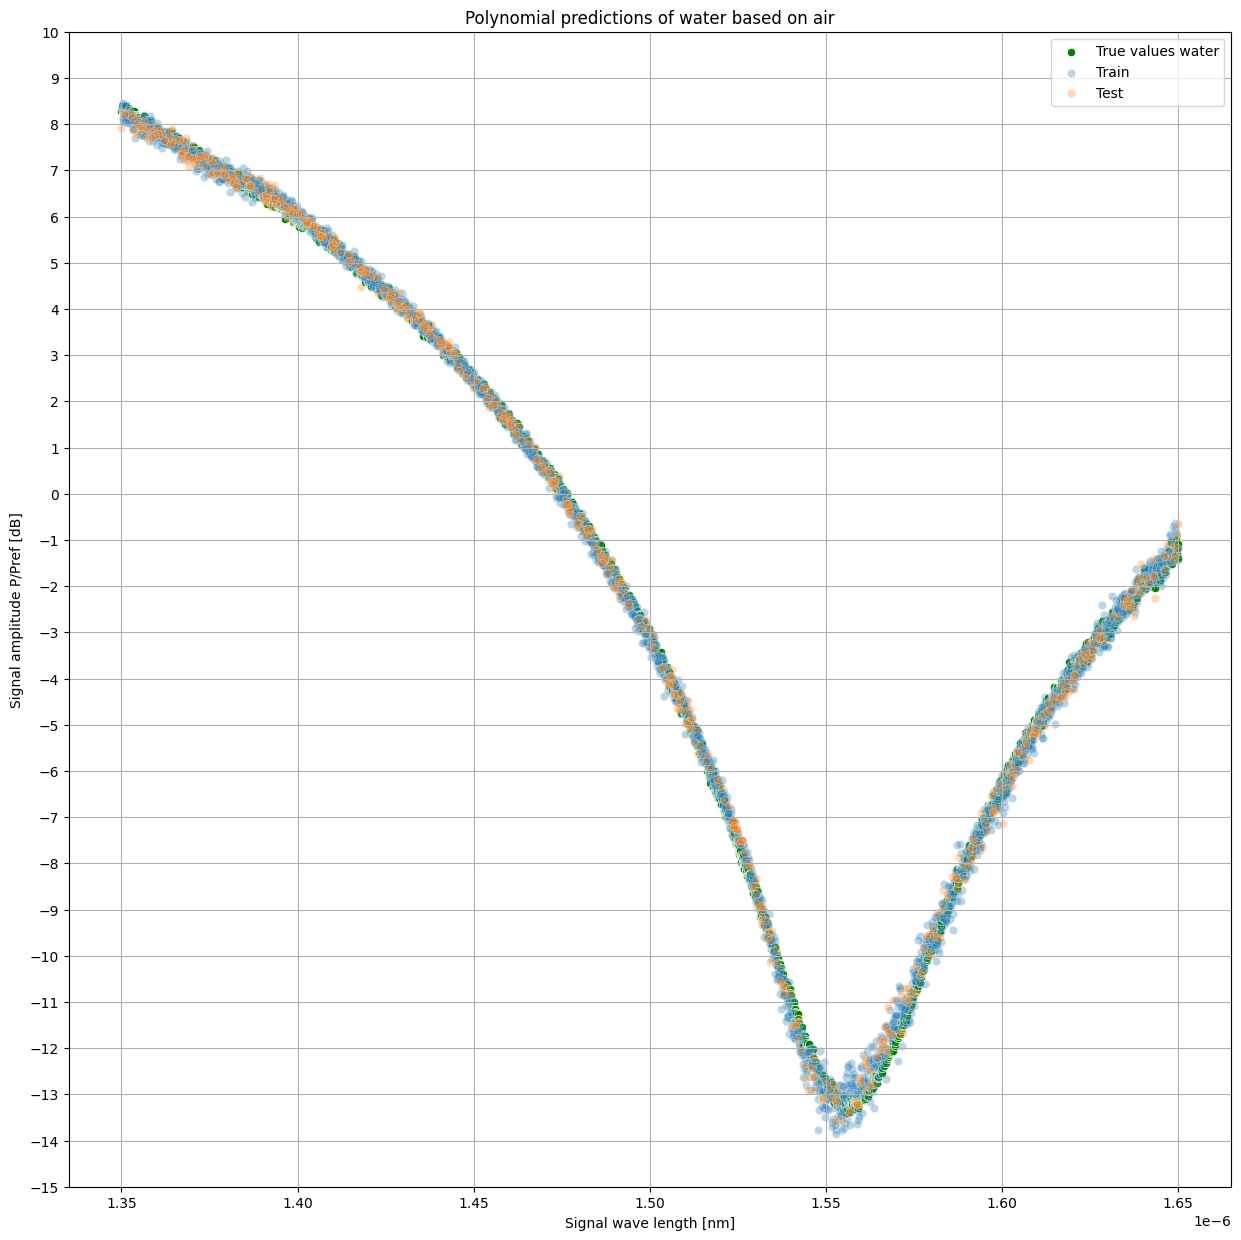

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='True values water', color='green')
sns.scatterplot(data=X_train_water_air, x='wave_length', y=poly_pred_train, label='Train', alpha=0.3)
sns.scatterplot(data=X_test_water_air, x='wave_length', y=poly_pred_test, label='Test', alpha=0.3)
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Polynomial predictions of water based on air")
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

SUMMARY:

Even for 2nd degree achieved very high metric r2 and errors close to 0. This can casue risk of overfitting - case for further investigation. But since on both sets (train and test) results are very close/similar it can be stated that is correct.

## Evaluate Algorithms: Data rescaling

### Evalate Algorithms: Normalization

In [ ]:
# Normalization the dataset
norm_pipeline_water = []
norm_pipeline_water.append(('NormalizedKNN', Pipeline([('Normalized', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
norm_pipeline_water.append(('NormalizedEN', Pipeline([('Normalized', MinMaxScaler()),('EN', ElasticNet())])))
norm_pipeline_water.append(('NormalizedCART', Pipeline([('Normalized', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
norm_pipeline_water.append(('NormalizedSVR', Pipeline([('Normalized', MinMaxScaler()),('SVR', SVR())])))

results = []
names = []
for name, model in norm_pipeline_water:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_water_air, y_train_water_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

NormalizedKNN: -0.006230 (0.000557)
NormalizedEN: -18.127909 (1.437850)
NormalizedCART: -0.008677 (0.000722)
NormalizedSVR: -0.011026 (0.000450)


### Evaluate Algorithms: Standardization

In [ ]:
# Standardize the dataset
ss_pipeline_water = []
ss_pipeline_water.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
ss_pipeline_water.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
ss_pipeline_water.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
ss_pipeline_water.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))

results = []
names = []
for name, model in ss_pipeline_water:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_water_air, y_train_water_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledKNN: -0.006267 (0.000584)
ScaledEN: -5.146319 (0.323100)
ScaledCART: -0.008670 (0.000785)
ScaledSVR: -0.011017 (0.000464)


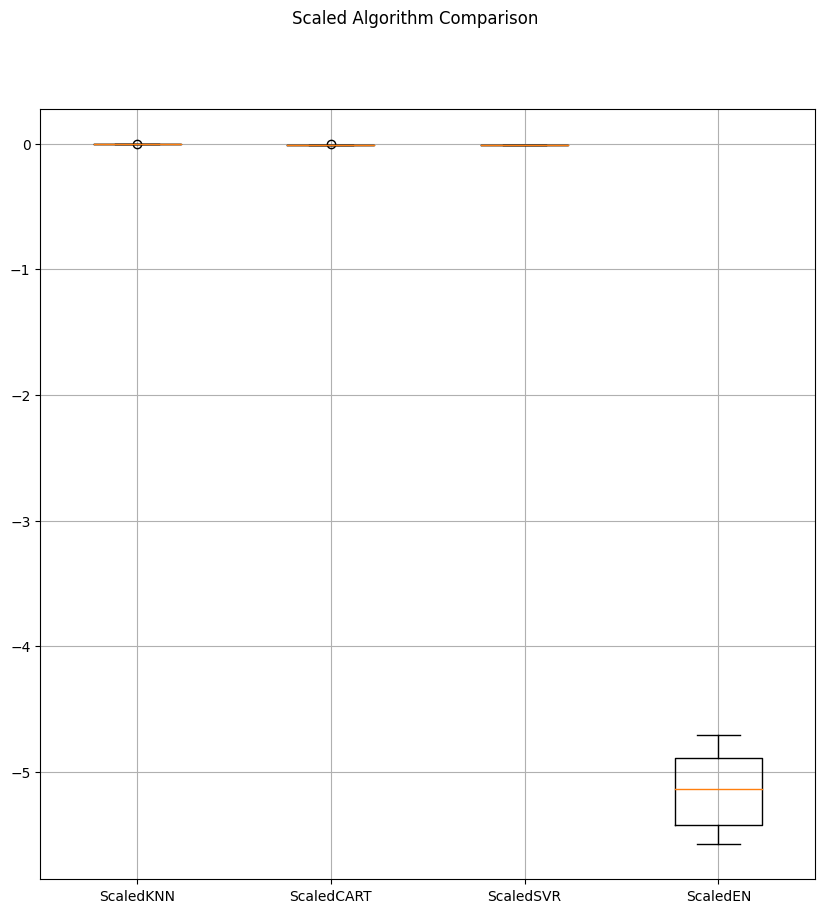

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

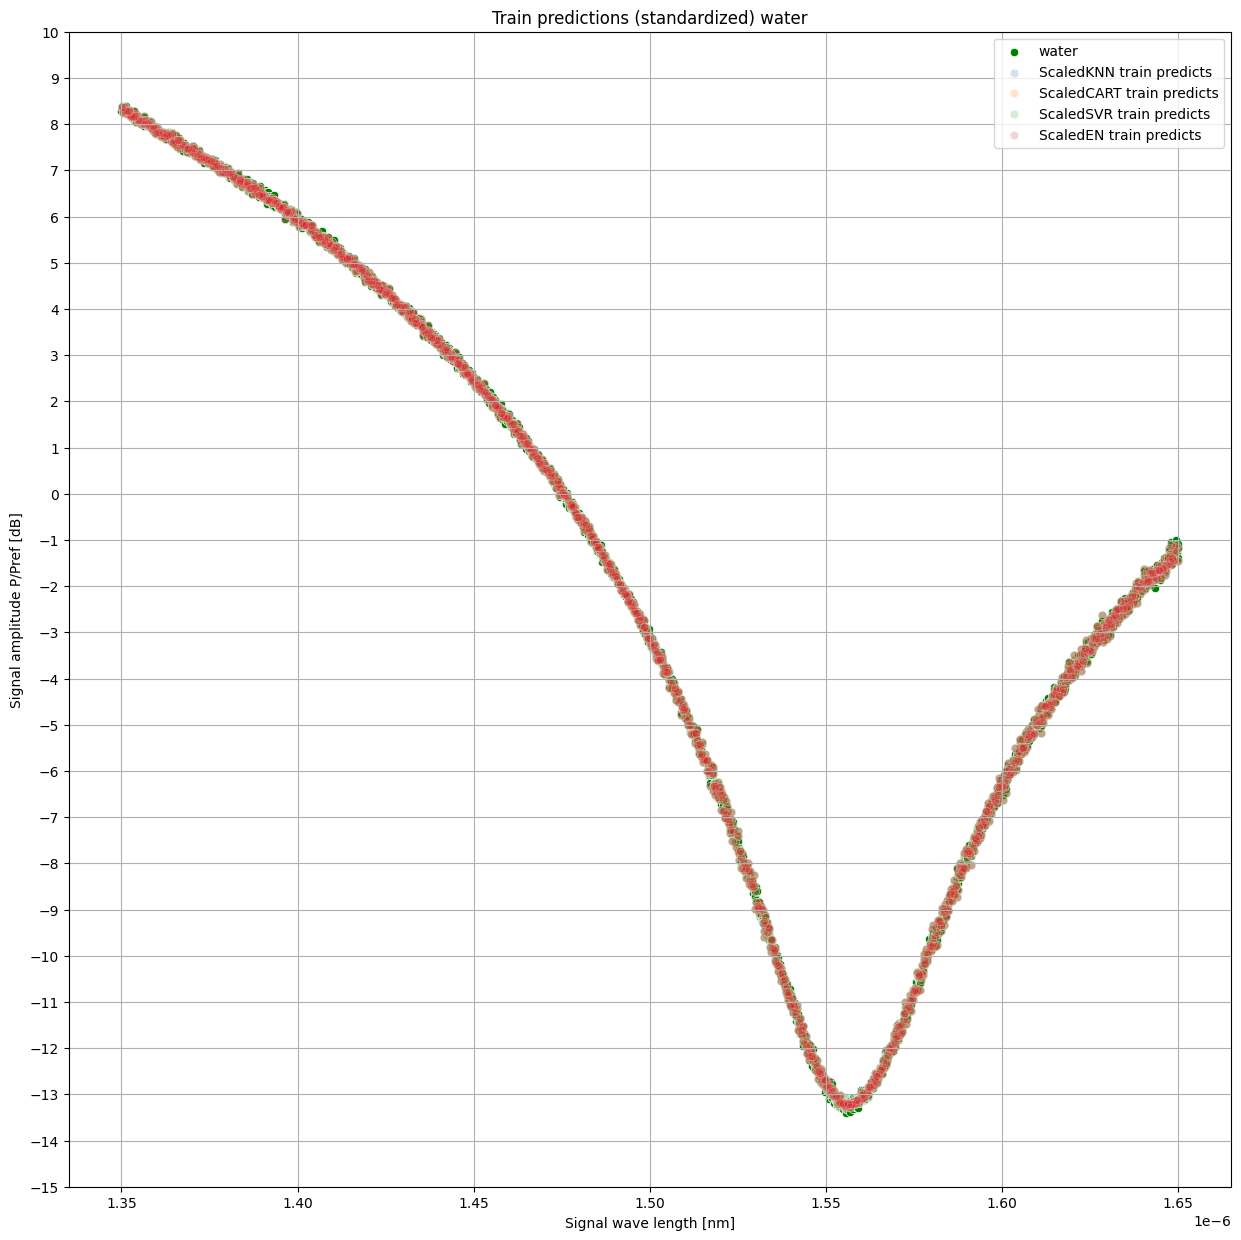

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Train predictions (standardized) water")
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water', color='green')

for name, elem in ss_pipeline_water:
  sns.scatterplot(data=X_train_water_air, x='wave_length', y=ss_pipeline_water[0][1].fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label= name+ ' train predicts', alpha=0.2)
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

SUMMARY:

Use of MinMaxScaler gives significant drop for Elasticnet (over -18 from -2). Rest of algorithms slightly increased.

In case of StandardScaler, KNN, CART and SVR have similar very low errors as in Normalization. At this stage this is suspiciously good - check parameters.

Standardization improved ElasticNet algorithm result. But result neither with Normalization nor Standardization is good as without rescaling.

## Ensemble Methods

In [ ]:
# ensembles
ensembles_water = []
ensembles_water.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles_water.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles_water.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles_water.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))

results = []
names = []
for name, model in ensembles_water:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_water_air, y_train_water_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: -0.387374 (0.039188)
ScaledGBM: -0.012114 (0.001545)
ScaledRF: -0.003197 (0.000394)
ScaledET: -0.002403 (0.000174)


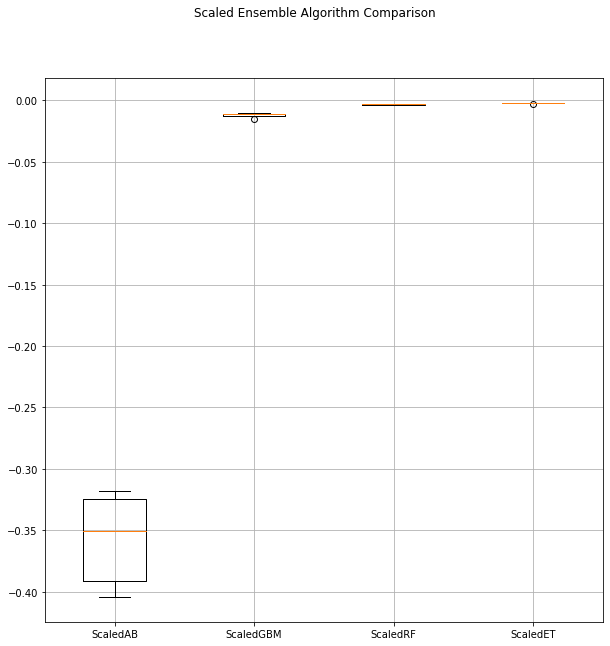

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

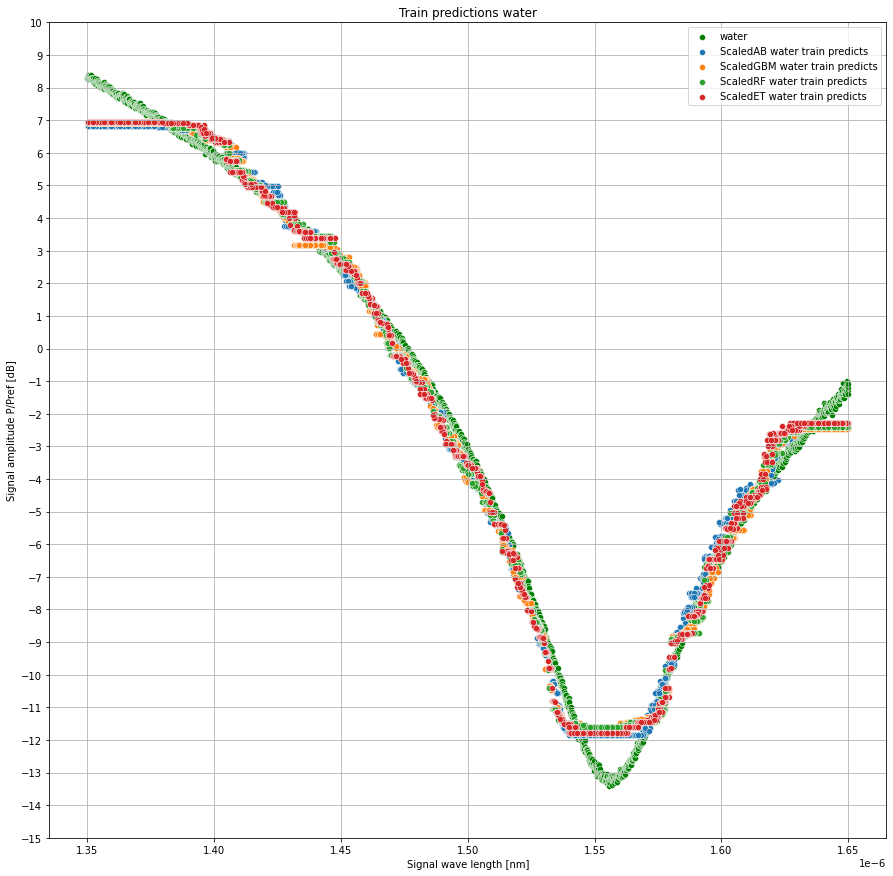

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Train predictions water")
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water', color='green')
for name, model in ensembles_water:
  sns.scatterplot(data=X_train_water_air, x='wave_length', y=ensembles_water[0][1].fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label= name+ ' water train predicts')
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

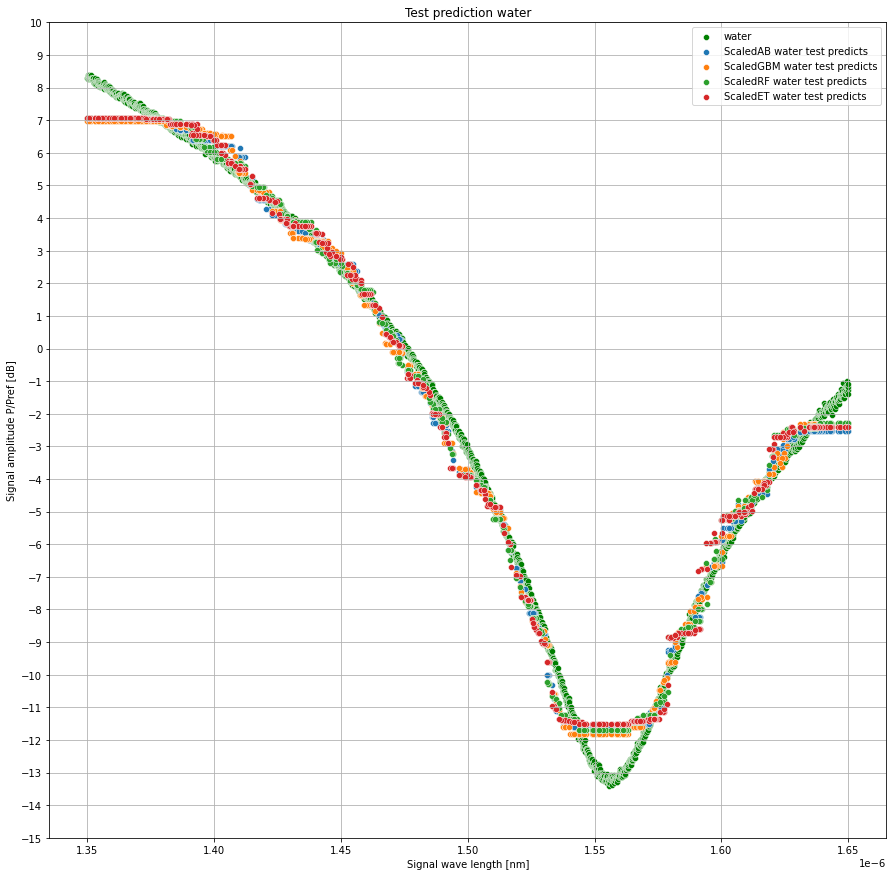

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Test prediction water")
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water', color='green')
for name, model in ensembles_water:
  sns.scatterplot(data=X_test_water_air, x='wave_length', y=ensembles_water[0][1].fit(X_test_water_air,y_test_water_air).predict(X_test_water_air), label= name+ ' water test predicts')
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

SUMMARY:

All ensemble methods seems to correct looking at plots. The worst but still good result has AdaBoost (-0,4). All the rest error is almost 0.

## Finalize Model

Chose ElasticNet for final model

In [ ]:
# model
model_final = ElasticNet()
model_final.fit(X_train_water_air, y_train_water_air)


# predictions on train and test
train_pred = model_final.predict(X_train_water_air)
test_pred = model_final.predict(X_test_water_air)


# prediction metrics
print('TRAIN metrics')
regression_results(y_train_water_air, train_pred)
print('\nTEST metrics')
regression_results(y_test_water_air, test_pred)

TRAIN metrics
explained_variance:  0.944
r2:  0.944
MAE:  1.3003
MSE:  2.3624
RMSE:  1.537

TEST metrics
explained_variance:  0.9471
r2:  0.9469
MAE:  1.2605
MSE:  2.2879
RMSE:  1.5126


## Summary

* Final model ElasticNet has very high metrics and is preferred to use in this task.
* ElasticNet prevents from overfitting which can appear in Polynomial.  
* Value from train and test sets and similar which means that model is stable
* Because of different scales of features, normalization is not enough, Standardization is better approach. 
* Standardization lowered the scores - final model without rescaling.
* Ensemble methods gives also good results but needs to checked further.

# Model build for Isopropanol based on air

In [ ]:
air_iso = pd.concat([air,iso['mean_iso']], axis=1)
set_option('display.precision',10)
air_iso

,wave_length,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,mean_iso
0,0.0000013500,9.1792,9.7793,7.8831,8.0963,9.4439,9.4554,8.8064,9.9081,8.6910,9.2124,8.48207000
1,0.0000013501,9.2003,9.8643,8.0971,8.1872,9.6645,9.6052,8.9714,10.0010,8.7223,9.2734,8.58722000
2,0.0000013502,9.1968,9.8031,7.9478,8.2061,9.5697,9.6264,8.9747,9.9366,8.7796,9.1703,8.54358000
3,0.0000013503,9.1028,9.7320,7.9979,8.1094,9.6378,9.5136,8.8461,9.8126,8.6753,9.2478,8.51922000
4,0.0000013504,9.0601,9.6895,7.9220,7.9691,9.4933,9.4042,8.8265,9.8773,8.6667,9.0771,8.46371000
...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0.0000016496,3.8310,3.5505,2.3074,1.5783,2.8330,2.4787,2.9408,3.7791,2.7312,3.2784,-1.09830500
2997,0.0000016497,3.8613,3.8237,2.3935,1.7888,2.9789,2.9384,3.2277,3.6568,2.7287,3.4213,-1.02440500
2998,0.0000016498,3.8361,3.6708,2.2550,1.3259,2.7841,2.4859,2.8527,3.7064,2.5725,3.3112,-1.14558900
2999,0.0000016499,3.9466,3.8785,2.4935,1.6945,2.9465,2.9317,3.3101,3.7920,2.7335,3.4500,-0.82895060


##  Dataset split for Isopropanol based on air

In [ ]:
# Split-out validation dataset
X_iso_air = air_iso.copy()
y_iso_air = X_iso_air.pop('mean_iso')

X_train_iso_air, X_test_iso_air, y_train_iso_air, y_test_iso_air = train_test_split(X_iso_air, y_iso_air, test_size=0.20, random_state=42)

print("X_train_iso_air dimension = ", X_train_iso_air.shape)
print("X_test_iso_air dimension = ", X_test_iso_air.shape)
print("y_train_iso_air dimension = ", y_train_iso_air.shape)
print("y_train_iso_air dimension = ", y_test_iso_air.shape)
X_train_iso_air.reset_index(inplace=True, drop=True)
X_test_iso_air.reset_index(inplace=True, drop=True)
y_train_iso_air.reset_index(inplace=True, drop=True)
y_test_iso_air.reset_index(inplace=True, drop=True)

X_train_iso_air dimension =  (2400, 11)
X_test_iso_air dimension =  (601, 11)
y_train_iso_air dimension =  (2400,)
y_train_iso_air dimension =  (601,)


## Evaluate Algorithms: Baseline

In [ ]:
# Spot-Check Algorithms
models_iso = []
models_iso.append(('KNN', KNeighborsRegressor()))
models_iso.append(('LASSO', Lasso()))
models_iso.append(('EN', ElasticNet()))
models_iso.append(('CART', DecisionTreeRegressor()))
models_iso.append(('SVR', SVR()))

In [ ]:
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models_iso:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_iso_air, y_train_iso_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

KNN: -0.010693 (0.001574)
LASSO: -3.391058 (0.113346)
EN: -2.745112 (0.094190)
CART: -0.260852 (0.308286)
SVR: -0.040710 (0.004333)


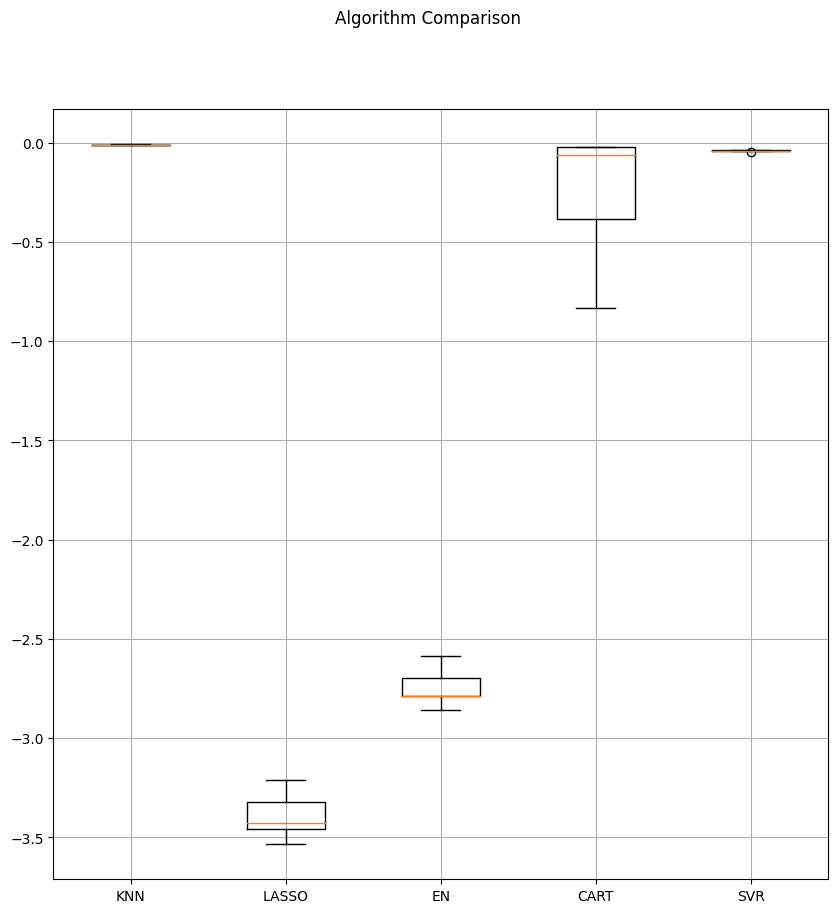

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

Plot-check predictions of baseline

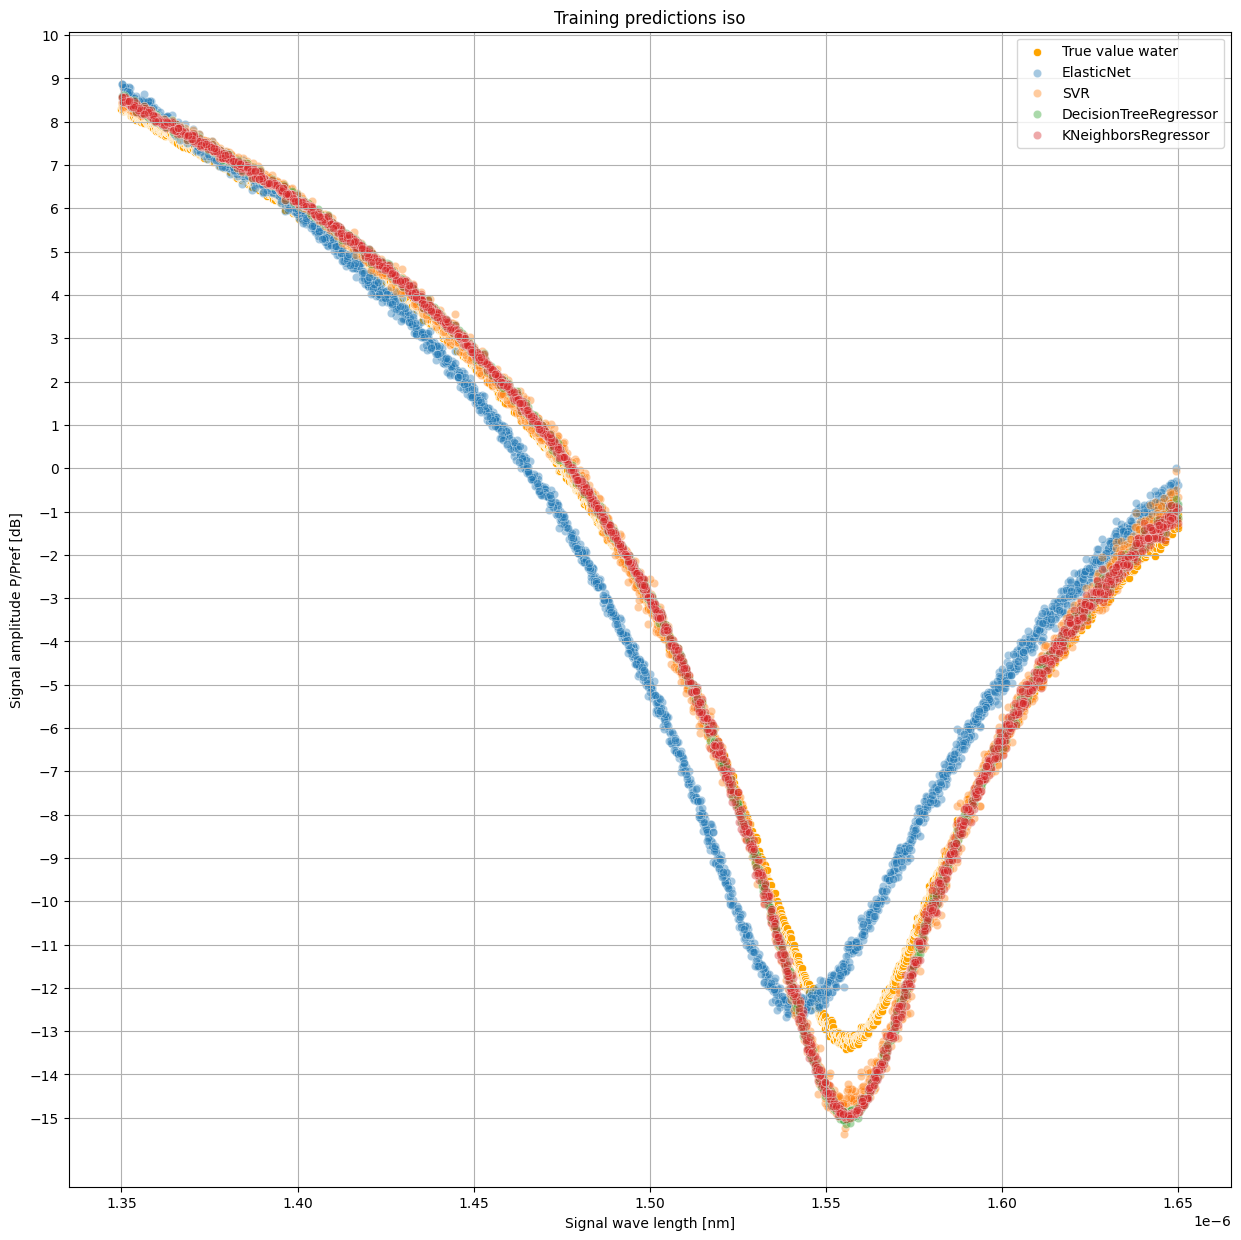

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='True value water', alpha=1, color='orange')
sns.scatterplot(data=X_train_iso_air, x='wave_length', y=ElasticNet().fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label='ElasticNet', alpha=0.4)
sns.scatterplot(data=X_train_iso_air, x='wave_length', y=SVR().fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label='SVR', alpha=0.4)
sns.scatterplot(data=X_train_iso_air, x='wave_length', y=DecisionTreeRegressor().fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label='DecisionTreeRegressor', alpha=0.4)
sns.scatterplot(data=X_train_iso_air, x='wave_length', y=KNeighborsRegressor().fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label='KNeighborsRegressor',alpha=0.4)
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Training predictions iso")
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

SUMMARY:

* Best score has KNN, the second is SVR and third CART. All have error below 0,3. That is suspicious - need to check results with non-default parameters.

* 4th place has ElasticNet with error -2,7 which is good for first try. Also Lasso has error -3,4. But since ElasticNet is regression with combined L1 and L2, Lasso will not be taken under consideration.

## Evaluate Algorithm: PolynomialFeatures

In [ ]:
poly2 = PolynomialFeatures(degree=2)
model_poly2 = LinearRegression()

X_train_poly2 = poly2.fit_transform(X_train_iso_air)
X_test_poly2 = poly2.transform(X_test_iso_air)

model_poly2.fit(X_train_poly2, y_train_iso_air)

poly2_pred_train = model_poly2.predict(X_train_poly2)
poly2_pred_test = model_poly2.predict(X_test_poly2)

In [ ]:
print('Train result')
regression_results(y_train_iso_air, poly2_pred_train)

Train result
explained_variance:  0.9985
r2:  0.9985
MAE:  0.1844
MSE:  0.0725
RMSE:  0.2692


In [ ]:
print('Test result')
regression_results(y_test_iso_air, poly2_pred_test)

Test result
explained_variance:  0.9987
r2:  0.9987
MAE:  0.1738
MSE:  0.0642
RMSE:  0.2534


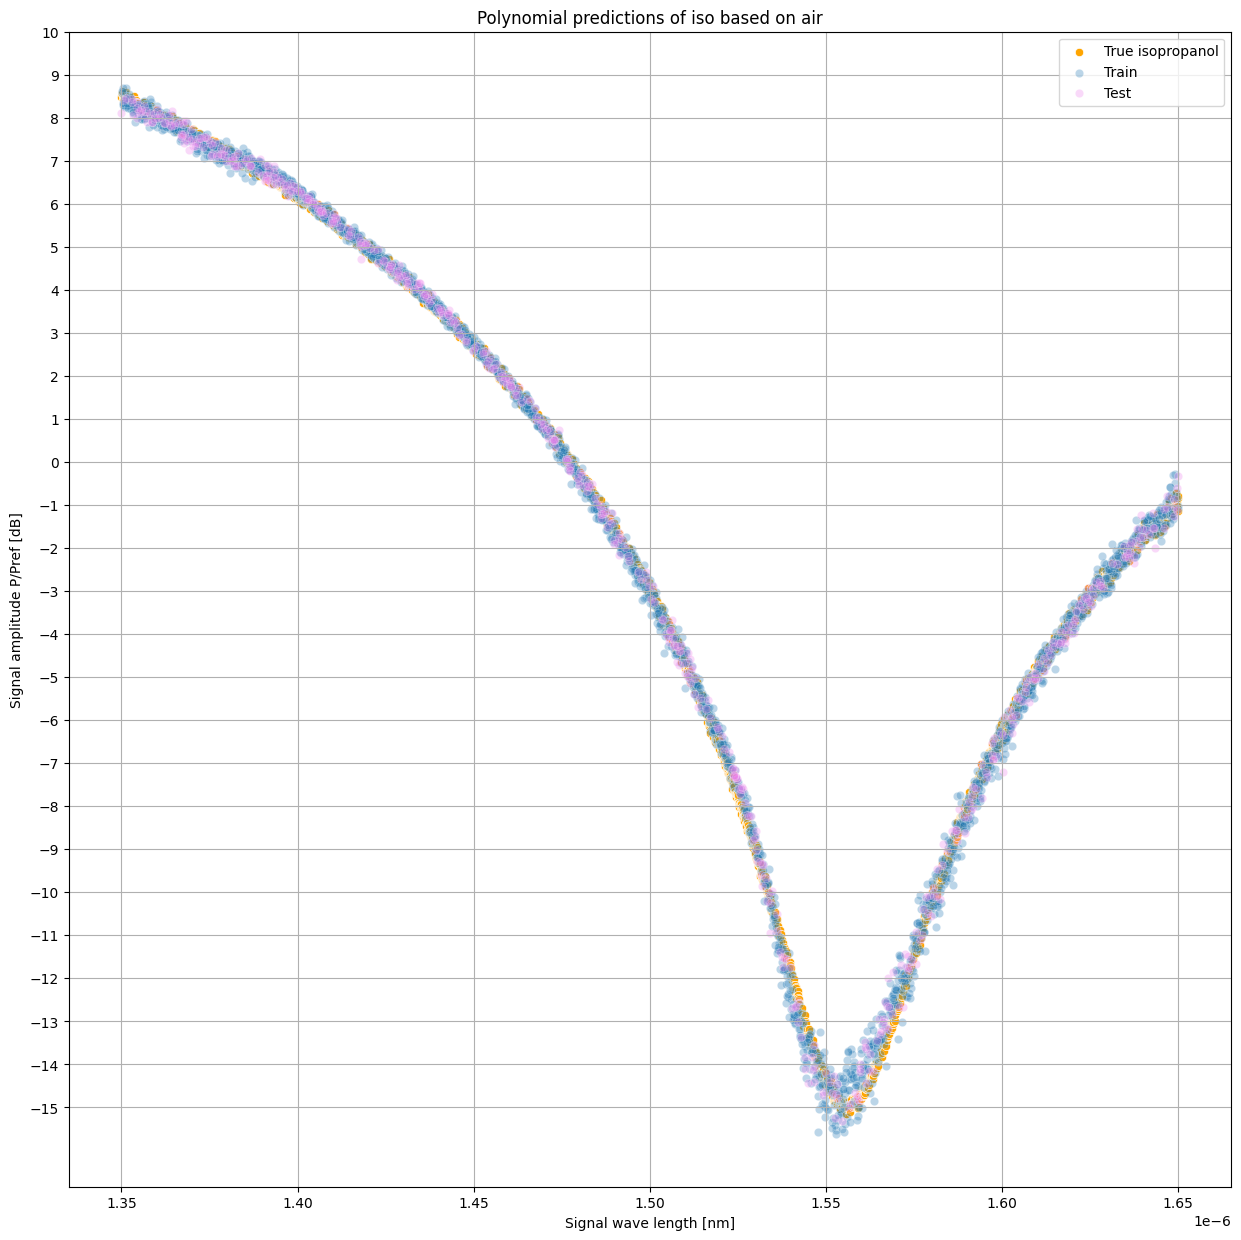

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='True isopropanol', color='orange')
sns.scatterplot(data=X_train_iso_air, x='wave_length', y=poly2_pred_train, label='Train', alpha=0.3)
sns.scatterplot(data=X_test_iso_air, x='wave_length', y=poly2_pred_test, label='Test', alpha=0.3, color='violet')
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Polynomial predictions of iso based on air")
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

SUMMARY:

Even for 2nd degree achieved very high metric r2 and errors close to 0. This can casue risk of overfitting - case for further investigation. But since on both sets (train and test) results are very close/similar it can be stated that is correct.

## Evaluate Algorithms: Data rescaling

### Evaluate Algorithms: Normalization

In [ ]:
# Normalization the dataset
norm_pipeline_iso = []
norm_pipeline_iso.append(('NormalizedKNN', Pipeline([('Normalized', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
norm_pipeline_iso.append(('NormalizedEN', Pipeline([('Normalized', MinMaxScaler()),('EN', ElasticNet())])))
norm_pipeline_iso.append(('NormalizedCART', Pipeline([('Normalized', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
norm_pipeline_iso.append(('NormalizedSVR', Pipeline([('Normalized', MinMaxScaler()),('SVR', SVR())])))

results = []
names = []
for name, model in norm_pipeline_iso:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_iso_air, y_train_iso_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

NormalizedKNN: -0.008398 (0.001129)
NormalizedEN: -20.612147 (1.752167)
NormalizedCART: -0.008815 (0.000680)
NormalizedSVR: -0.017508 (0.001384)


### Evaluate Algorithms: Standardization

In [ ]:
# Standardize the dataset
ss_pipeline_iso = []
ss_pipeline_iso.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
ss_pipeline_iso.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
ss_pipeline_iso.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
ss_pipeline_iso.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))

results = []
names = []
for name, model in ss_pipeline_iso:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_iso_air, y_train_iso_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledKNN: -0.008473 (0.001163)
ScaledEN: -6.703168 (0.445178)
ScaledCART: -0.077932 (0.137811)
ScaledSVR: -0.017504 (0.001383)


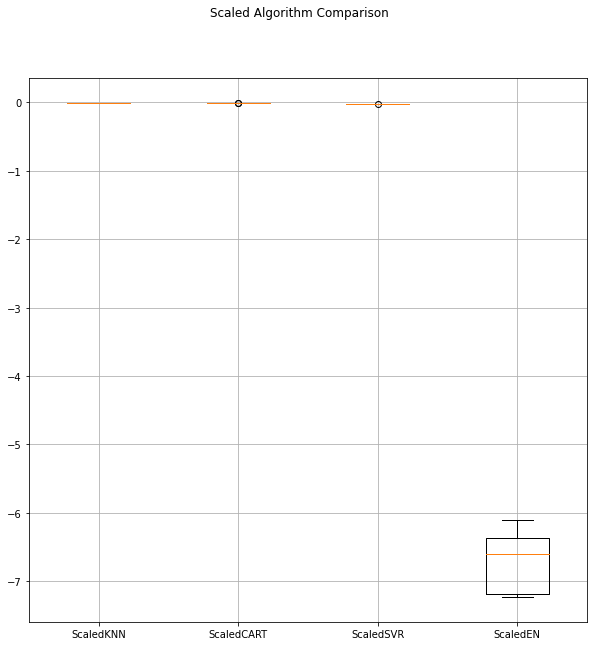

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

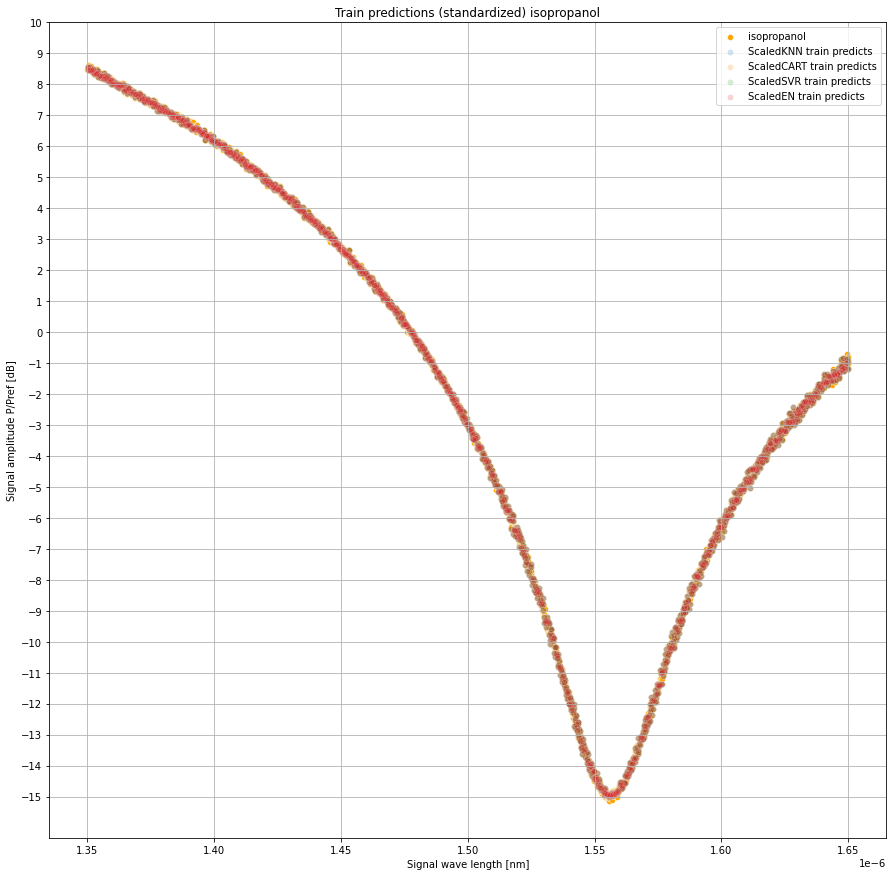

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Train predictions (standardized) isopropanol")
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol', color='orange')
for name, elem in ss_pipeline_iso:
  sns.scatterplot(data=X_train_iso_air, x='wave_length', y=ss_pipeline_iso[0][1].fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label= name+ ' train predicts', alpha=0.2)
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

SUMMARY:

Use of MinMaxScaler gives minor increase of KNN, CART and SVR but caused high drop for Elasticnet (over -20).

In case of StandardScaler, KNN, CART and SVR have similar very low errors as in Normalization. At this stage this is suspiciously good - check parameters.

Standardization improved ElasticNet algorithm result to -6,7. But result neither with Normalization nor Standardization is good as without rescaling.

## Ensemble Methods

In [ ]:
# ensembles
ensembles_iso = []
ensembles_iso.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles_iso.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles_iso.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles_iso.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))

results = []
names = []
for name, model in ensembles_iso:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_iso_air, y_train_iso_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: -0.449871 (0.039665)
ScaledGBM: -0.013649 (0.002654)
ScaledRF: -0.004182 (0.000961)
ScaledET: -0.002802 (0.000231)


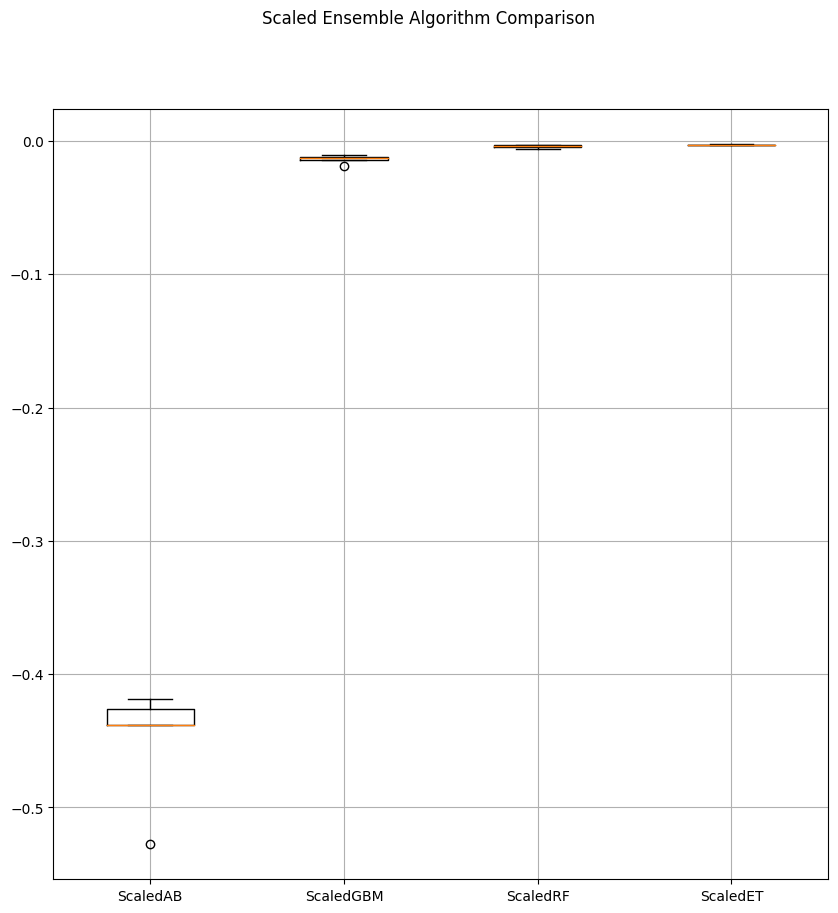

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.grid()
plt.show()

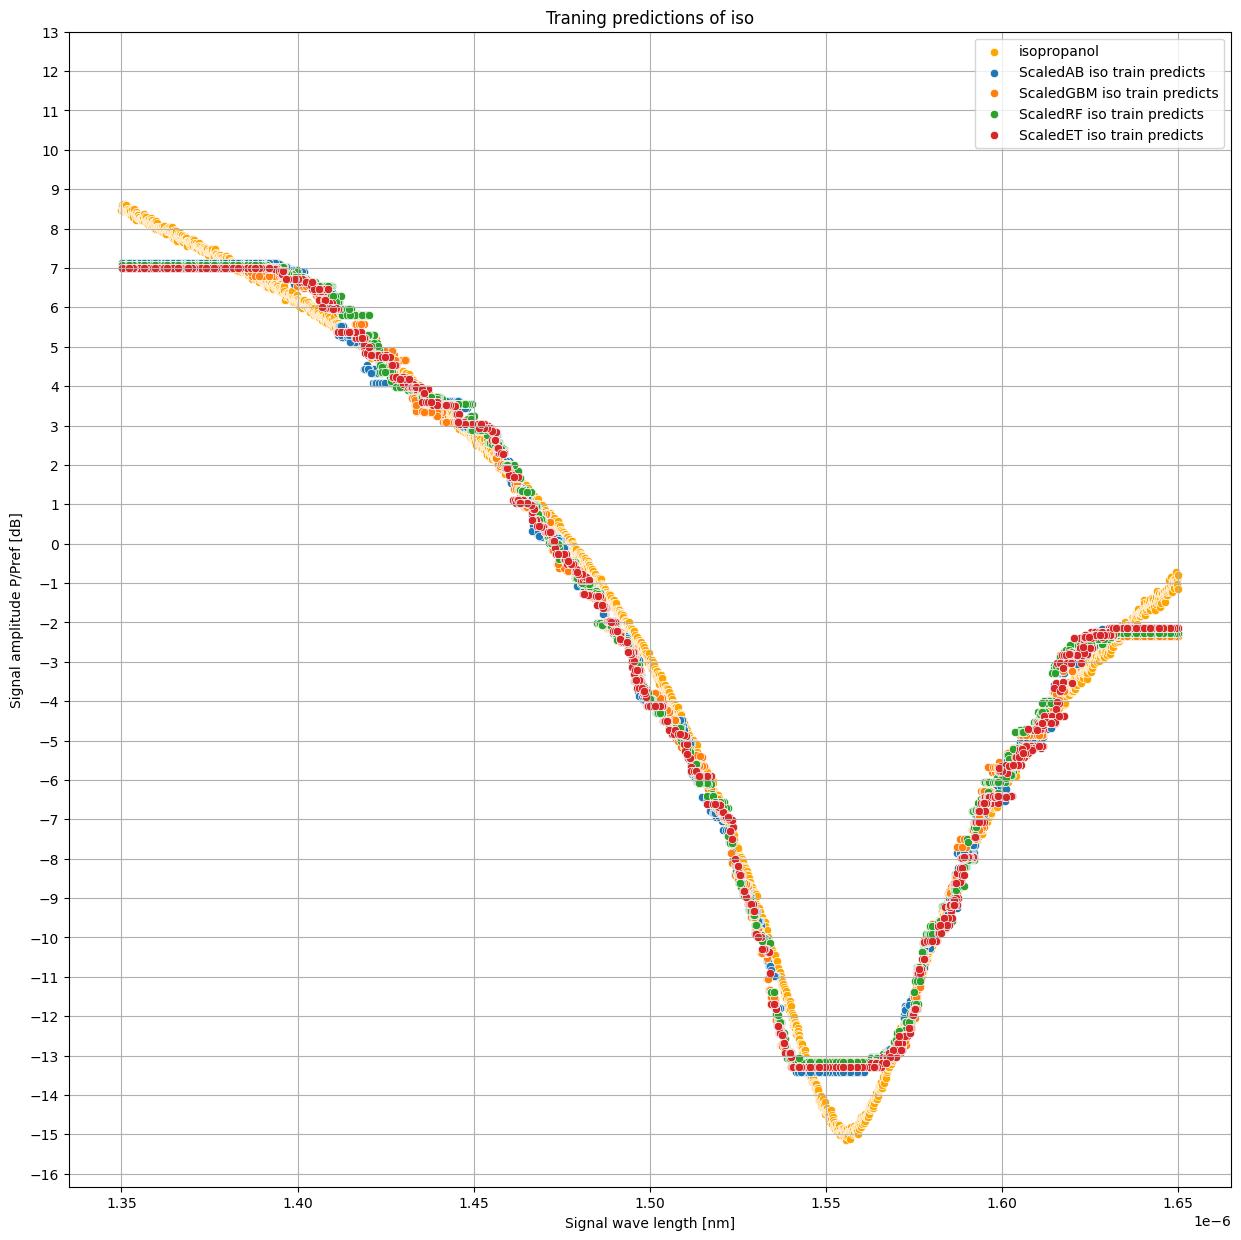

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Traning predictions of iso")
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol', color='orange')
for name, model in ensembles_iso:
  sns.scatterplot(data=X_train_iso_air, x='wave_length', y=ensembles_iso[0][1].fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label= name+ ' iso train predicts')
plt.grid()
plt.yticks(np.arange(-16, 14, step=1))
plt.legend()

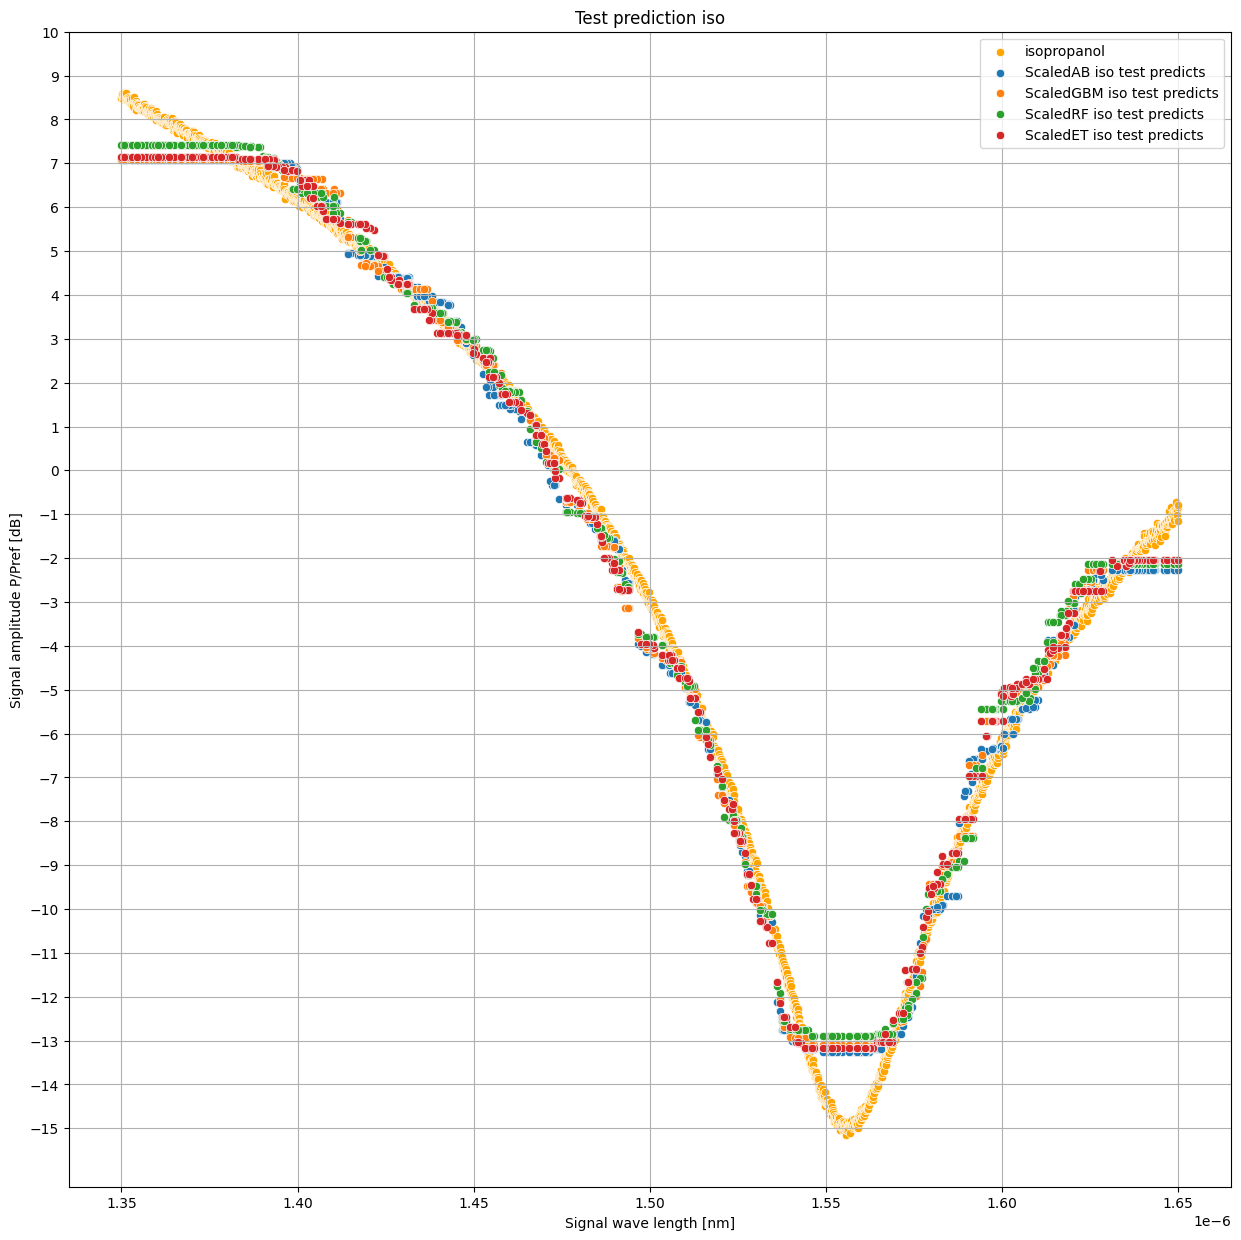

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Test prediction iso")
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol', color='orange')
for name, model in ensembles_iso:
  sns.scatterplot(data=X_test_iso_air, x='wave_length', y=ensembles_iso[0][1].fit(X_test_iso_air,y_test_iso_air).predict(X_test_iso_air), label= name+ ' iso test predicts')
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

SUMMARY:

All ensemble methods seems to correct looking at plots. The worst but still good result has AdaBoost (~ -0,45). All the rest error is almost 0.

## Finalize Model

In [ ]:
# model
model_final = ElasticNet()
model_final.fit(X_train_iso_air, y_train_iso_air)

# predictions on train and test
train_pred = model_final.predict(X_train_iso_air)
test_pred = model_final.predict(X_test_iso_air)

# prediction metrics
print('TRAIN metrics')
regression_results(y_train_iso_air, train_pred)
print('\nTEST metrics')
regression_results(y_test_iso_air, test_pred)

TRAIN metrics
explained_variance:  0.9426
r2:  0.9426
MAE:  1.3069
MSE:  2.7388
RMSE:  1.6549

TEST metrics
explained_variance:  0.9453
r2:  0.9452
MAE:  1.2567
MSE:  2.6526
RMSE:  1.6287


## Summary

* Final model ElasticNet has very high metrics and is preferred to use in this task.
* ElasticNet prevents from overfitting which can appear in Polynomial.  
* Value from train and test sets and similar which means that model is stable
* Because of different scales of features, normalization is not enough, Standardization is better approach. 
* Standardization lowered the scores - final model without rescaling.
* Ensemble methods gives also good results but needs to checked further.

# Further analysis proposition

* Production code should check possible outliers and replace with e.g. mean or median
* Set thresholds for result on which sensor will be classified as good or not
* Tuning of used algorithms 
* Check algoorithms with suspicious low error.